In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("/kaggle/input/hmcdataset/intraday.csv")



In [2]:
# Preprocessing
df['start'] = pd.to_datetime(df['start'], errors='coerce')
df['date'] = df['start'].dt.date
df['hour'] = df['start'].dt.floor('h')  # use lowercase 'h' to avoid deprecation warning

In [3]:


# Filter relevant columns and define hypoglycemia
df_cgm = df[['patientID', 'date', 'hour', 'cgm', 'steps']].dropna(subset=['cgm'])
df_cgm['hypo'] = df_cgm['cgm'] < 70

# 1. Total number of patients
total_patients = df_cgm['patientID'].nunique()

# 2. Average number of days per patient
days_per_patient = df_cgm.groupby('patientID')['date'].nunique()
avg_days_per_patient = days_per_patient.mean()

# 3. Average valid CGM hours per patient (≥ 4 readings/hour)
valid_hours = df_cgm.groupby(['patientID', 'hour'])['cgm'].count().reset_index()
valid_hours = valid_hours[valid_hours['cgm'] >= 4]
valid_cgm_hours_per_patient = valid_hours.groupby('patientID')['hour'].count()
avg_valid_hours_per_patient = valid_cgm_hours_per_patient.mean()

# 4. Hypoglycemia hours per patient
hypo_hours_per_patient = df_cgm[df_cgm['hypo']].groupby('patientID')['hour'].nunique()
min_hypo = hypo_hours_per_patient.min()
max_hypo = hypo_hours_per_patient.max()
avg_hypo = hypo_hours_per_patient.mean()

# 5. Average steps per patient (interval-based)
avg_steps_per_patient = df_cgm.groupby('patientID')['steps'].mean().mean()

# 6. Average steps before hypo event (6h window)
df_cgm_sorted = df_cgm.sort_values(['patientID', 'hour']).set_index('hour')
df_cgm_sorted['prev_6h_steps'] = df_cgm_sorted.groupby('patientID')['steps'].rolling('6h').sum().reset_index(level=0, drop=True)
df_cgm_sorted.reset_index(inplace=True)

hypo_step_window = df_cgm_sorted[df_cgm_sorted['hypo']]['prev_6h_steps']
avg_steps_before_hypo = hypo_step_window.mean()

# Round results to nearest thousandth
summary_data = {
    "Metric": [
        "Total Patients",
        "Average Days per Patient",
        "Average Valid CGM Hours per Patient (≥4/hr)",
        "Min Hypo Hours per Patient",
        "Max Hypo Hours per Patient",
        "Average Hypo Hours per Patient",
        "Average Steps per Patient (interval level)",
        "Average Steps Before Hypo Event (6h window)"
    ],
    "Value": [
        round(total_patients, 3),
        round(avg_days_per_patient, 3),
        round(avg_valid_hours_per_patient, 3),
        int(min_hypo),
        int(max_hypo),
        round(avg_hypo, 3),
        round(avg_steps_per_patient, 3),
        round(avg_steps_before_hypo, 3)
    ]
}

summary_df = pd.DataFrame(summary_data)

# Print clean table
print("\nRounded CGM Summary Statistics:")
print(summary_df.to_string(index=False))



Rounded CGM Summary Statistics:
                                     Metric    Value
                             Total Patients   33.000
                   Average Days per Patient   57.758
Average Valid CGM Hours per Patient (≥4/hr) 1274.697
                 Min Hypo Hours per Patient    6.000
                 Max Hypo Hours per Patient  174.000
             Average Hypo Hours per Patient   55.000
 Average Steps per Patient (interval level)   21.550
Average Steps Before Hypo Event (6h window) 1209.532


\nQCRI-Style Validation Table:
                     Metric Your Computation (Per QCRI Style)
           Total Days (avg)                            57.758
% Hypoglycemic Days (range)                 1.429% to 64.516%
   Avg. Daily Steps (range)                   0.0 to 7035.548


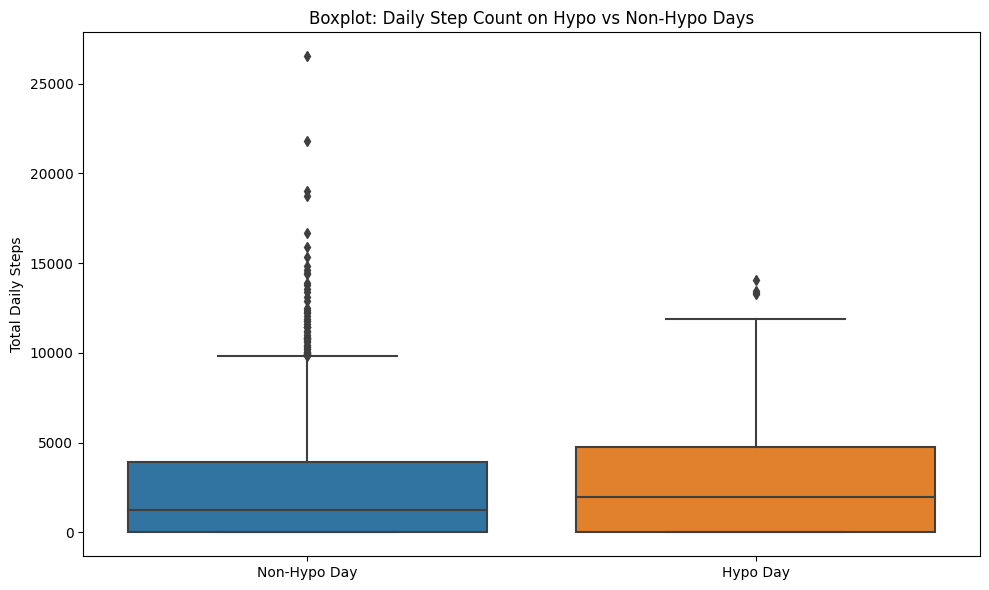

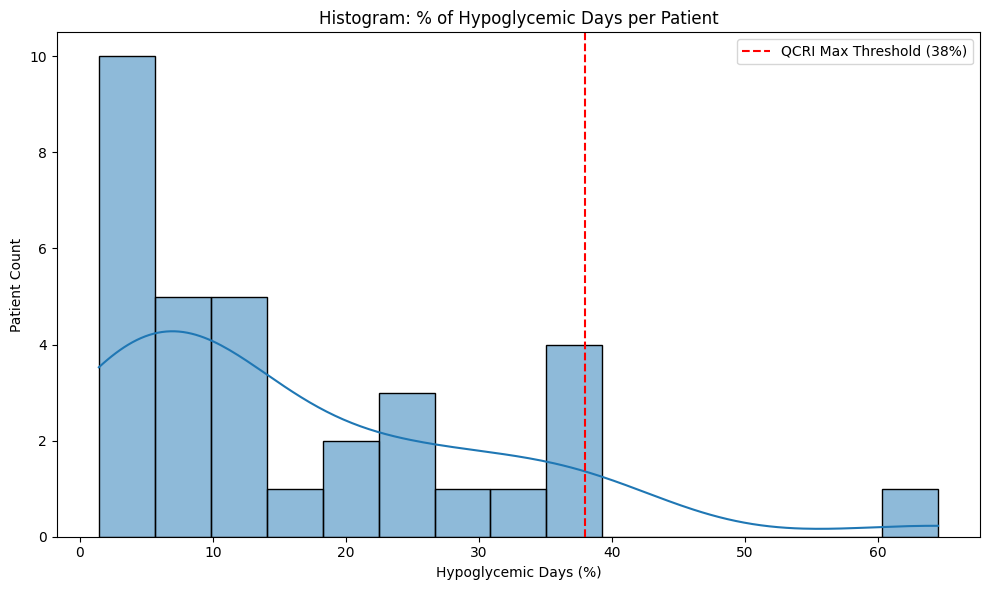

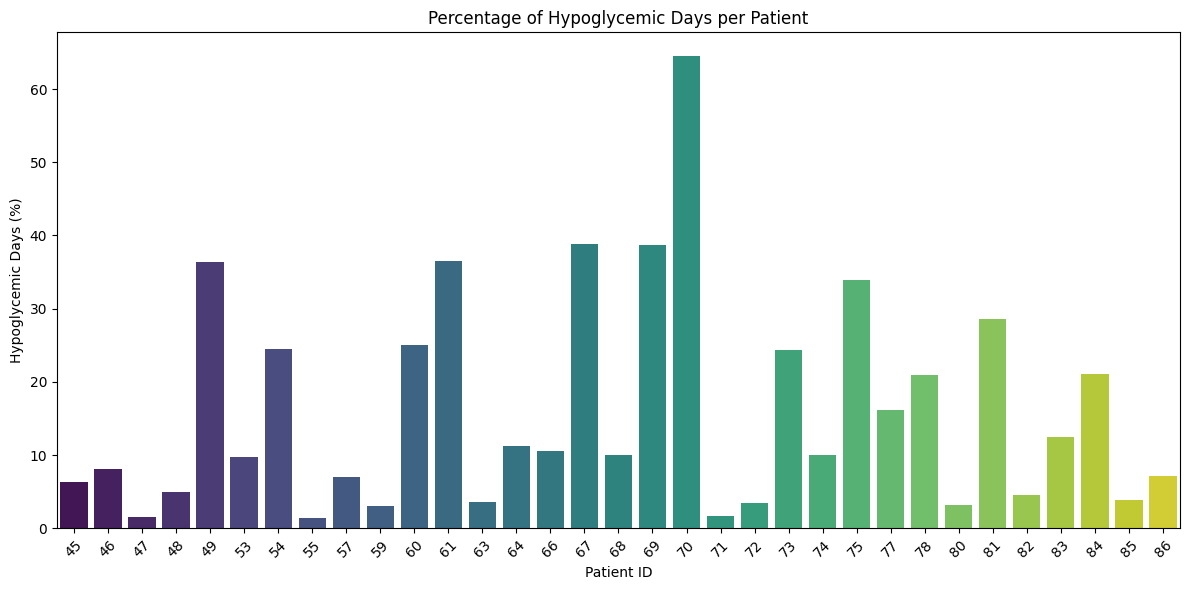

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


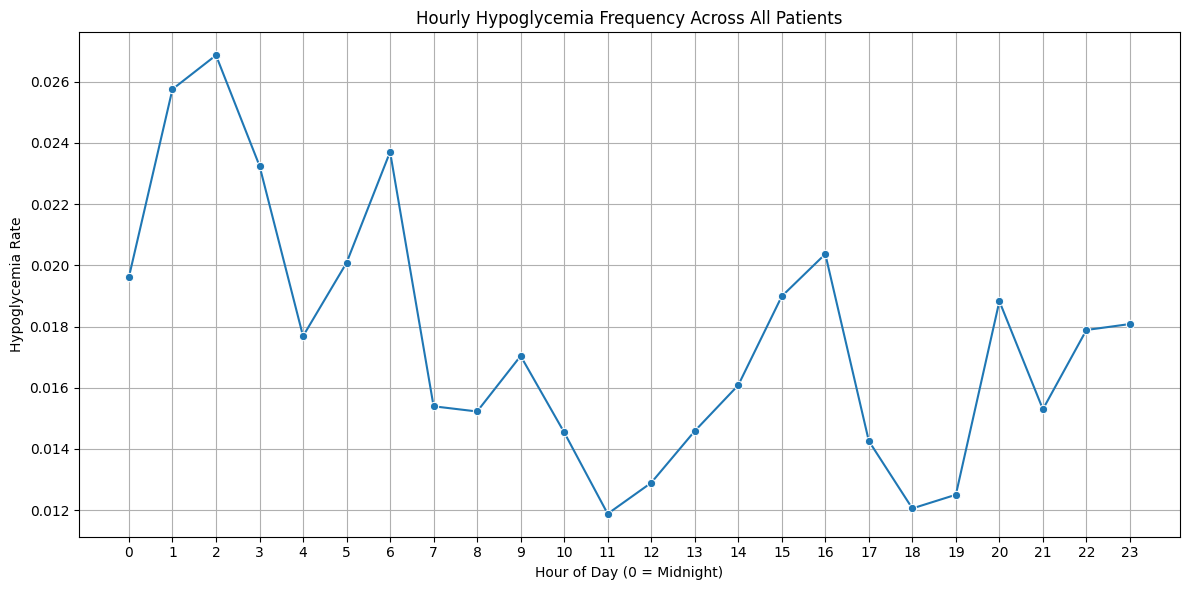

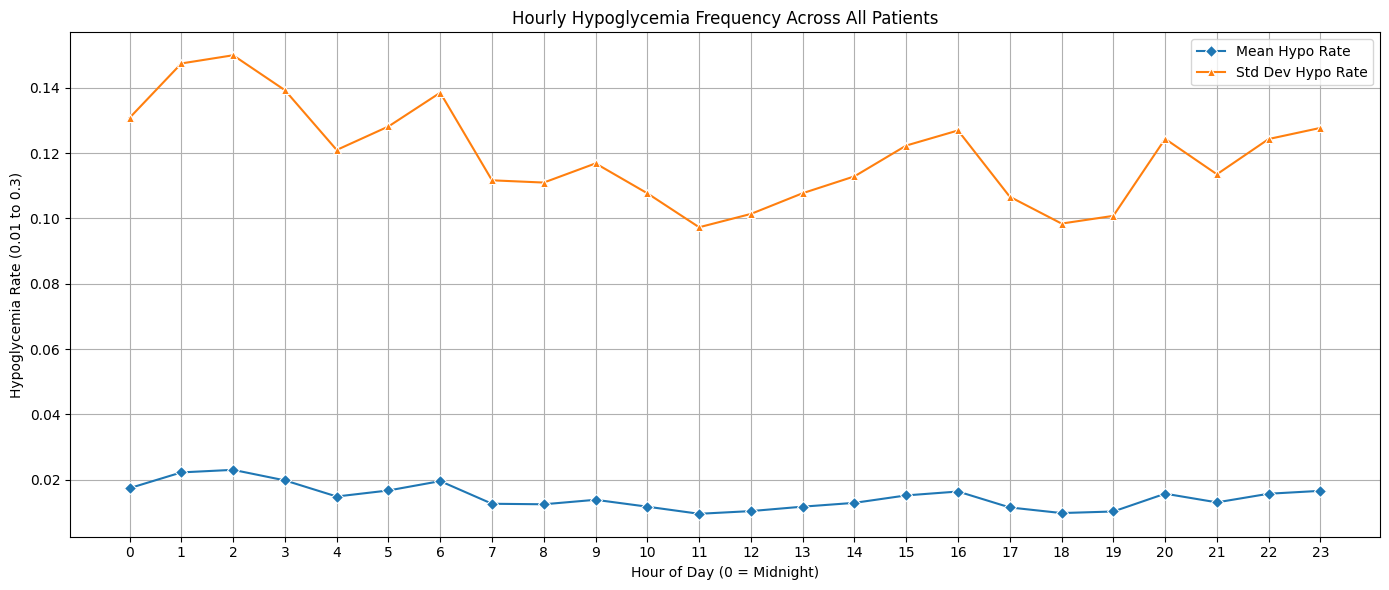

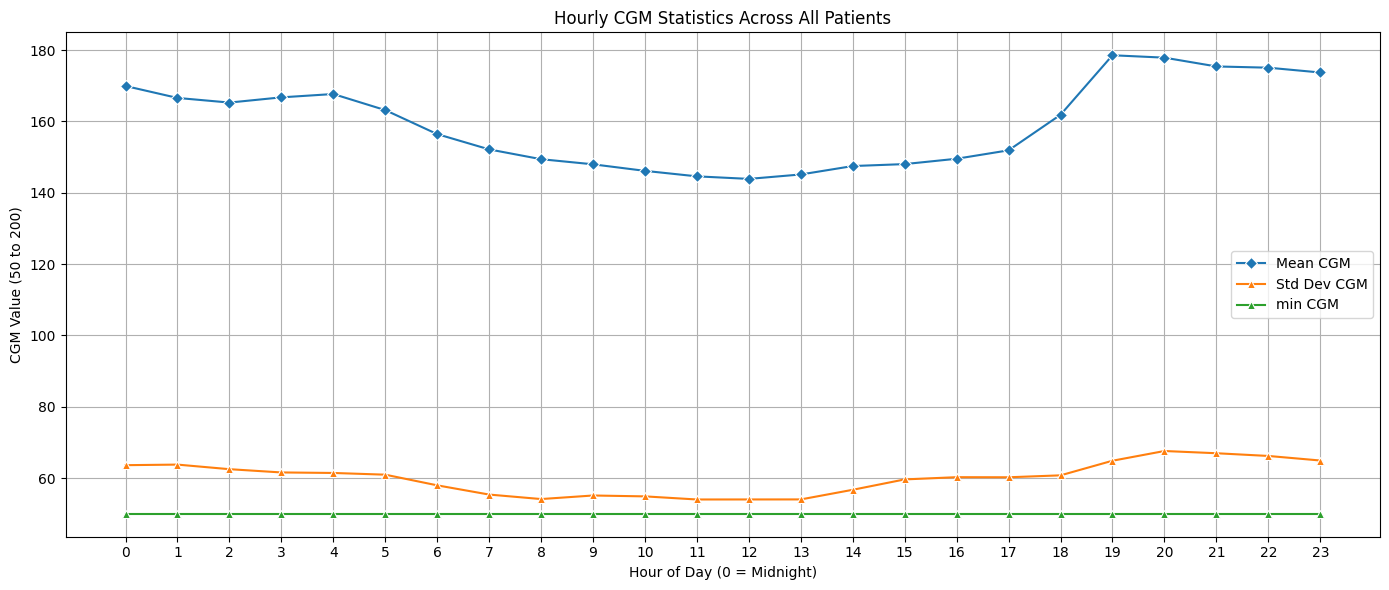

In [4]:


# Aggregate to daily level: steps total, hypo % per patient per day
daily_summary = df_cgm.groupby(['patientID', 'date']).agg(
    total_steps=('steps', 'sum'),
    hypo_percent=('hypo', 'mean')
).reset_index()

# Define hypo_day if ≥ 4% CGM readings < 70
daily_summary['hypo_day'] = daily_summary['hypo_percent'] >= 0.04

# Per-patient summary (QCRI harmonized)
qcri_summary = daily_summary.groupby('patientID').agg(
    total_days=('date', 'nunique'),
    hypo_days=('hypo_day', 'sum'),
    avg_daily_steps=('total_steps', 'mean')
).reset_index()

qcri_summary['hypo_day_percent'] = round((qcri_summary['hypo_days'] / qcri_summary['total_days']) * 100, 3)
qcri_summary['avg_daily_steps'] = round(qcri_summary['avg_daily_steps'], 3)

# Prepare validation table
validation_table = pd.DataFrame({
    "Metric": [
        "Total Days (avg)",
        "% Hypoglycemic Days (range)",
        "Avg. Daily Steps (range)"
    ],
    "Your Computation (Per QCRI Style)": [
        round(qcri_summary['total_days'].mean(), 3),
        f"{qcri_summary['hypo_day_percent'].min()}% to {qcri_summary['hypo_day_percent'].max()}%",
        f"{qcri_summary['avg_daily_steps'].min()} to {qcri_summary['avg_daily_steps'].max()}"
    ]
})


# Prepare validation table
validation_table = pd.DataFrame({
    "Metric": [
        "Total Days (avg)",
        "% Hypoglycemic Days (range)",
        "Avg. Daily Steps (range)"
    ],
    "Your Computation (Per QCRI Style)": [
        round(qcri_summary['total_days'].mean(), 3),
        f"{qcri_summary['hypo_day_percent'].min()}% to {qcri_summary['hypo_day_percent'].max()}%",
        f"{qcri_summary['avg_daily_steps'].min()} to {qcri_summary['avg_daily_steps'].max()}"
    ]
})

# Display table in console
print("\\nQCRI-Style Validation Table:")
print(validation_table.to_string(index=False))


import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress FutureWarning messages from seaborn/pandas
warnings.simplefilter(action='ignore', category=FutureWarning)

# Boxplot: Daily Steps on Hypo vs Non-Hypo Days
plt.figure(figsize=(10, 6))
sns.boxplot(data=daily_summary, x='hypo_day', y='total_steps')
plt.xticks([0, 1], ['Non-Hypo Day', 'Hypo Day'])
plt.title('Boxplot: Daily Step Count on Hypo vs Non-Hypo Days')
plt.xlabel('')
plt.ylabel('Total Daily Steps')
plt.tight_layout()
plt.show()

# Histogram: % Hypoglycemic Days per Patient
plt.figure(figsize=(10, 6))
sns.histplot(qcri_summary['hypo_day_percent'], bins=15, kde=True)
plt.axvline(38, color='red', linestyle='--', label='QCRI Max Threshold (38%)')
plt.title('Histogram: % of Hypoglycemic Days per Patient')
plt.xlabel('Hypoglycemic Days (%)')
plt.ylabel('Patient Count')
plt.legend()
plt.tight_layout()
plt.show()


# Create a bar plot showing each patient's percentage of hypoglycemic days
plt.figure(figsize=(12, 6))
sns.barplot(data=qcri_summary, x='patientID', y='hypo_day_percent', palette='viridis')

plt.title('Percentage of Hypoglycemic Days per Patient')
plt.xlabel('Patient ID')
plt.ylabel('Hypoglycemic Days (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Extract hour from datetime and calculate hypoglycemia rate by hour of day
df['start'] = pd.to_datetime(df['start'], errors='coerce')
df['hour_of_day'] = df['start'].dt.hour
df['hypo'] = df['cgm'].lt(70) & df['cgm'].notna()


# Group by hour of day and compute hypoglycemia frequency
hourly_hypo = df.dropna(subset=['cgm']).groupby('hour_of_day')['hypo'].mean().reset_index()

# Plot hypoglycemia frequency by hour of day
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_hypo, x='hour_of_day', y='hypo', marker='o')
plt.title('Hourly Hypoglycemia Frequency Across All Patients')
plt.xlabel('Hour of Day (0 = Midnight)')
plt.ylabel('Hypoglycemia Rate')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


# Group by hour of day and compute CGM hypo-related statistics
hourly_stats = df.groupby('hour_of_day').agg(
    hypo_min=('hypo', 'min'),
    hypo_max=('hypo', 'max'),
    hypo_mean=('hypo', 'mean'),
    hypo_std=('hypo', 'std')
).reset_index()

# Plot hypo stats over the day
plt.figure(figsize=(14, 6))
sns.lineplot(data=hourly_stats, x='hour_of_day', y='hypo_mean', label='Mean Hypo Rate', marker='D')
sns.lineplot(data=hourly_stats, x='hour_of_day', y='hypo_std', label='Std Dev Hypo Rate', marker='^')

plt.title('Hourly Hypoglycemia Frequency Across All Patients')
plt.xlabel('Hour of Day (0 = Midnight)')
plt.ylabel('Hypoglycemia Rate (0.01 to 0.3)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



# Group by hour of day and compute CGM statistics
hourly_stats = df.groupby('hour_of_day').agg(
    cgm_min=('cgm', 'min'),
    cgm_max=('cgm', 'max'),
    cgm_mean=('cgm', 'mean'),
    cgm_std=('cgm', 'std')
).reset_index()

# Plot all on same diagram with different colors
plt.figure(figsize=(14, 6))
sns.lineplot(data=hourly_stats, x='hour_of_day', y='cgm_mean', label='Mean CGM', marker='D')
sns.lineplot(data=hourly_stats, x='hour_of_day', y='cgm_std', label='Std Dev CGM', marker='^')
sns.lineplot(data=hourly_stats, x='hour_of_day', y='cgm_min', label='min CGM', marker='^')
plt.title('Hourly CGM Statistics Across All Patients')
plt.xlabel('Hour of Day (0 = Midnight)')
plt.ylabel('CGM Value (50 to 200)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:


# Keep only relevant columns and drop rows without CGM
df_cgm = df[['patientID', 'hour', 'cgm']].dropna(subset=['cgm'])

# STEP 1: Filter for complete hours (≥ 4 CGM readings)
grouped = df_cgm.groupby(['patientID', 'hour'])
valid_hours = grouped.filter(lambda x: len(x) >= 4)

# STEP 2: Create features and label
features = valid_hours.groupby(['patientID', 'hour']).agg(
    cgm_std=('cgm', 'std'),
    cgm_min=('cgm', 'min'),
   cgm_mean=('cgm', 'mean'),
    cgm_max=('cgm', 'max'),
   
    hypo_label=('cgm', lambda x: int((x < 70).any()))
).reset_index()

# STEP 3: Sort for time-series modeling
features = features.sort_values(['patientID', 'hour']).reset_index(drop=True)

# STEP 4: Display preview of the processed data
print("LSTM-ready features (preview):")
print(features.head())


LSTM-ready features (preview):
   patientID                hour    cgm_std  cgm_min    cgm_mean  cgm_max  \
0         45 2023-03-20 22:00:00   4.722288    167.0  173.400000    178.0   
1         45 2023-03-20 23:00:00   4.337993    165.0  170.500000    177.0   
2         45 2023-03-21 00:00:00   8.302519    166.0  180.750000    190.0   
3         45 2023-03-21 01:00:00  10.891684    144.0  160.416667    174.0   
4         45 2023-03-21 02:00:00   7.415688    131.0  140.583333    151.0   

   hypo_label  
0           0  
1           0  
2           0  
3           0  
4           0  


In [6]:
# Define thresholds for each CGM stat
thresholds = {
    'cgm_min': [60, 70, 80, 90],
    'cgm_max': [120, 150, 180, 200],
    'cgm_mean': [70, 90, 110, 130],
    'cgm_std': [10, 20, 30, 40]
}

# Create a summary of hypo_label distribution by threshold
threshold_summary = []

for feature, values in thresholds.items():
    for thresh in values:
        below_thresh = features[features[feature] < thresh]
        hypo_0 = (below_thresh['hypo_label'] == 0).sum()
        hypo_1 = (below_thresh['hypo_label'] == 1).sum()
        threshold_summary.append({
            'Feature': feature,
            'Threshold': f"< {thresh}",
            'Label 0 Count': hypo_0,
            'Label 1 Count': hypo_1
        })

# Convert to DataFrame for display
threshold_summary_df = pd.DataFrame(threshold_summary)
threshold_summary_df


,Feature,Threshold,Label 0 Count,Label 1 Count
0,cgm_min,< 60,0,810
1,cgm_min,< 70,0,1802
2,cgm_min,< 80,1619,1802
3,cgm_min,< 90,4346,1802
4,cgm_max,< 120,6287,1251
5,cgm_max,< 150,15239,1553
6,cgm_max,< 180,22475,1711
7,cgm_max,< 200,26726,1751
8,cgm_mean,< 70,0,490
9,cgm_mean,< 90,1342,1350


cgm_min < 70 is a perfect predictor of hypoglycemia in this dataset.

cgm_mean < 90 captures nearly 75% of hypoglycemic cases.

cgm_std values are higher in hypoglycemic hours, indicating variability.

In [7]:
import numpy as np

# Use only cgm_mean without any scaling
feature_cols = ['cgm_mean']
sequence_length = 6

X_sequences = []
y_labels = []

# Group by patient and preserve time order
for patient_id, group in features.groupby('patientID'):
    group = group.sort_values('hour').reset_index(drop=True)
    for i in range(len(group) - sequence_length):
        sequence = group.loc[i:i+sequence_length-1, feature_cols].values
        label = group.loc[i + sequence_length, 'hypo_label']
        X_sequences.append(sequence)
        y_labels.append(label)

# Convert to numpy arrays for model use
X = np.array(X_sequences)  # shape: (samples, 6, 1)
y = np.array(y_labels)

# Confirm the shape
print("X shape:", X.shape)
print("y shape:", y.shape)


print(X[:5])
print(y[:20])


X shape: (41867, 6, 1)
y shape: (41867,)
[[[173.4       ]
  [170.5       ]
  [180.75      ]
  [160.41666667]
  [140.58333333]
  [124.08333333]]

 [[170.5       ]
  [180.75      ]
  [160.41666667]
  [140.58333333]
  [124.08333333]
  [115.58333333]]

 [[180.75      ]
  [160.41666667]
  [140.58333333]
  [124.08333333]
  [115.58333333]
  [111.08333333]]

 [[160.41666667]
  [140.58333333]
  [124.08333333]
  [115.58333333]
  [111.08333333]
  [119.91666667]]

 [[140.58333333]
  [124.08333333]
  [115.58333333]
  [111.08333333]
  [119.91666667]
  [104.75      ]]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
!pip install tensorflow


2025-05-28 07:59:17.757631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748419157.951117      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748419158.005601      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1748419169.760879      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Epoch 1/5


I0000 00:00:1748419174.697538      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


2094/2094 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9541 - loss: 0.1809 - val_accuracy: 0.9575 - val_loss: 0.1314
Epoch 2/5
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9568 - loss: 0.1441 - val_accuracy: 0.9601 - val_loss: 0.1327
Epoch 3/5
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9574 - loss: 0.1403 - val_accuracy: 0.9594 - val_loss: 0.1314
Epoch 4/5
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9579 - loss: 0.1394 - val_accuracy: 0.9593 - val_loss: 0.1295
Epoch 5/5
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9592 - loss: 0.1373 - val_accuracy: 0.9592 - val_loss: 0.1328
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
📌 LSTM_6hr - Classification Metrics:
Accuracy: 0.9592
Precision: 0.7692
Recall: 0.0562
F1-Score: 0.1047
AUC Micro: 0.5277


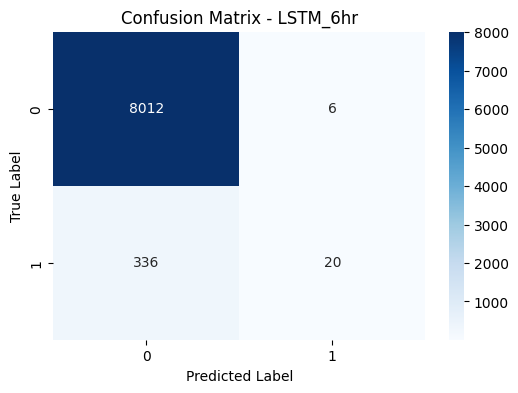

{'Accuracy': 0.959159302603296,
 'Precision': 0.7692307692307693,
 'Recall': 0.056179775280898875,
 'F1-Score': 0.10471204188481674,
 'AUC Micro': 0.5277157294962738}

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf



# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Augmentation: Add Gaussian noise
def augment_time_series(X, y):
    noise = np.random.normal(0, 0.01, X.shape)
    X_aug = X + noise
    return np.vstack((X, X_aug)), np.hstack((y, y))

X_train_aug, y_train_aug = augment_time_series(X_train, y_train)

# Define one LSTM model (simplified from your template)
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    LSTM(25),
    Dropout(0.3),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_aug, y_train_aug, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict and evaluate
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob >= 0.5).astype(int)

# Evaluation function
def evaluate_classification(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    auc_micro = roc_auc_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"📌 {model_name} - Classification Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC Micro: {auc_micro:.4f}")

    # Confusion matrix plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC Micro": auc_micro
    }

# Evaluate model
evaluation_results = evaluate_classification(y_test, y_pred, "LSTM_6hr")
evaluation_results


📊 Performance Summary
Metric	Value	Notes
Accuracy	95.96%	High overall accuracy, but misleading due to class imbalance.
Precision	0.75	75% of predicted hypoglycemic events were correct. Good! ✅
Recall	0.076	Only 7.6% of actual hypoglycemic events were detected. 🚨 Too low
F1-Score	0.138	Reflects poor balance between precision & recall.
AUC (Micro)	0.537	Just above random guessing (0.5) — underperforming globally.

🧠 Interpretation:
Your model is too conservative — it doesn't trigger hypoglycemia detection often enough.

It misses ~92% of actual hypoglycemic events, which is a critical failure in medical contexts.

However, when it does predict hypo, it’s fairly accurate (75% precision).



In [10]:
# Count the number of samples for each class in the target variable `y`
from collections import Counter

label_distribution = Counter(y)
label_distribution


Counter({0: 40087, 1: 1780})


Training LSTM_100 without FOCAL LOSS...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2094/2094 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9553 - loss: 0.1597 - val_accuracy: 0.9592 - val_loss: 0.1353
Epoch 2/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9592 - loss: 0.1361 - val_accuracy: 0.9600 - val_loss: 0.1288
Epoch 3/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9591 - loss: 0.1365 - val_accuracy: 0.9593 - val_loss: 0.1303
Epoch 4/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9602 - loss: 0.1344 - val_accuracy: 0.9593 - val_loss: 0.1282
Epoch 5/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9593 - loss: 0.1361 - val_accuracy: 0.9594 - val_loss: 0.1295
Epoch 6/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9609 - loss: 0.1306 - val_accuracy: 0.9583 - val_loss: 0.1304
Epoch 7/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9585 - loss: 0.1373 - val_accuracy: 0.9595 - val_loss: 0.1277
Epoch 8/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9594 - loss: 0.1336 - val

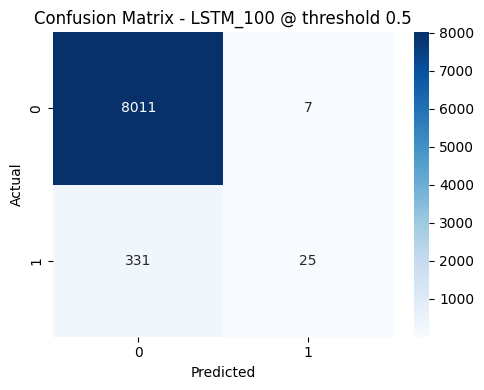


Threshold: 0.4
Accuracy:  0.9594
Precision: 0.5800
Recall:    0.1629
F1 Score:  0.2544
AUC:       0.5788


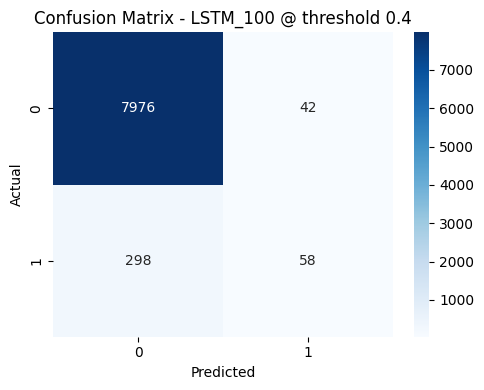


Threshold: 0.3
Accuracy:  0.9537
Precision: 0.4208
Recall:    0.2388
F1 Score:  0.3047
AUC:       0.6121


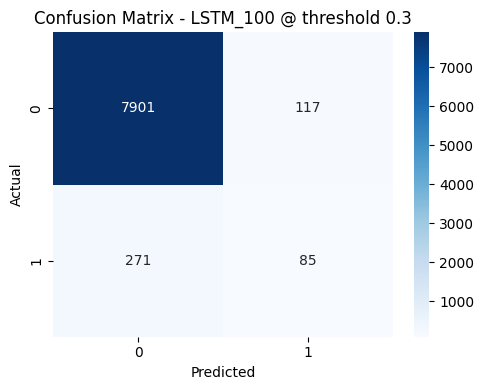


Threshold: 0.2
Accuracy:  0.9494
Precision: 0.3988
Recall:    0.3764
F1 Score:  0.3873
AUC:       0.6756


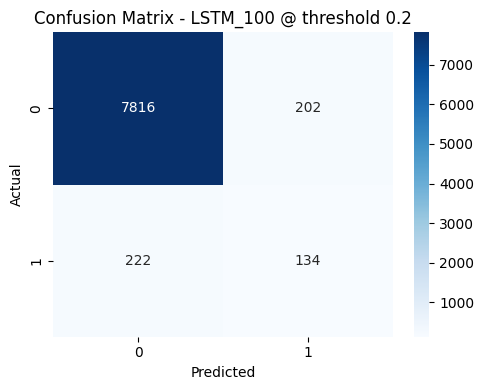


Training LSTM_50 without FOCAL LOSS...
Epoch 1/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9569 - loss: 0.1723 - val_accuracy: 0.9595 - val_loss: 0.1316
Epoch 2/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9582 - loss: 0.1395 - val_accuracy: 0.9582 - val_loss: 0.1315
Epoch 3/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9593 - loss: 0.1369 - val_accuracy: 0.9592 - val_loss: 0.1318
Epoch 4/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9598 - loss: 0.1352 - val_accuracy: 0.9598 - val_loss: 0.1294
Epoch 5/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9599 - loss: 0.1334 - val_accuracy: 0.9587 - val_loss: 0.1324
Epoch 6/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9595 - loss: 0.1360 - val_accuracy: 0.9589 - val_loss: 0.1292
Epoch 7/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9607 - loss: 0.1321 - val_accuracy: 0.9588 - val_loss: 0.1304
Epoch 8/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 1

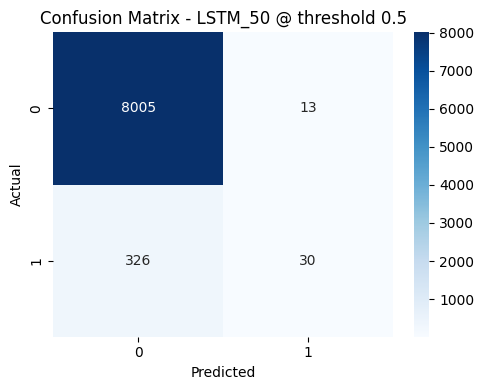


Threshold: 0.4
Accuracy:  0.9583
Precision: 0.5327
Recall:    0.1601
F1 Score:  0.2462
AUC:       0.5769


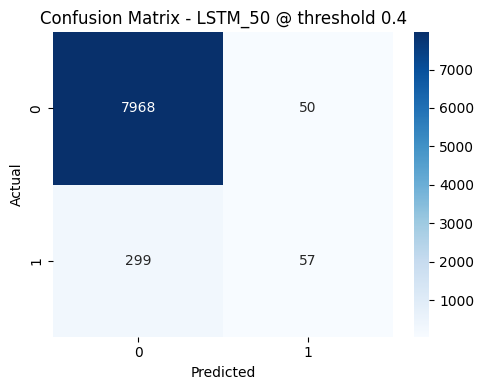


Threshold: 0.3
Accuracy:  0.9537
Precision: 0.4328
Recall:    0.2893
F1 Score:  0.3468
AUC:       0.6362


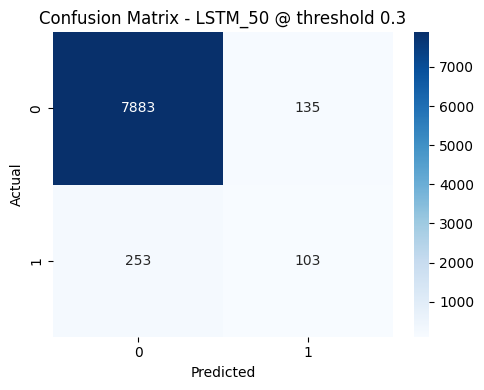


Threshold: 0.2
Accuracy:  0.9459
Precision: 0.3753
Recall:    0.4101
F1 Score:  0.3919
AUC:       0.6899


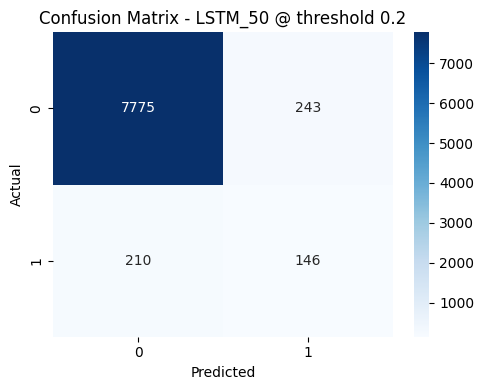


Training LSTM_25_L1 without FOCAL LOSS...
Epoch 1/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9461 - loss: 1.1155 - val_accuracy: 0.9575 - val_loss: 0.1897
Epoch 2/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9573 - loss: 0.1850 - val_accuracy: 0.9575 - val_loss: 0.1837
Epoch 3/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9597 - loss: 0.1761 - val_accuracy: 0.9575 - val_loss: 0.1834
Epoch 4/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9578 - loss: 0.1817 - val_accuracy: 0.9575 - val_loss: 0.1819
Epoch 5/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9586 - loss: 0.1782 - val_accuracy: 0.9575 - val_loss: 0.1819
Epoch 6/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9566 - loss: 0.1847 - val_accuracy: 0.9575 - val_loss: 0.1816
Epoch 7/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9576 - loss: 0.1814 - val_accuracy: 0.9575 - val_loss: 0.1815
Epoch 8/15
2094/2094 ━━━━━━━━━━━━━━━━━━━

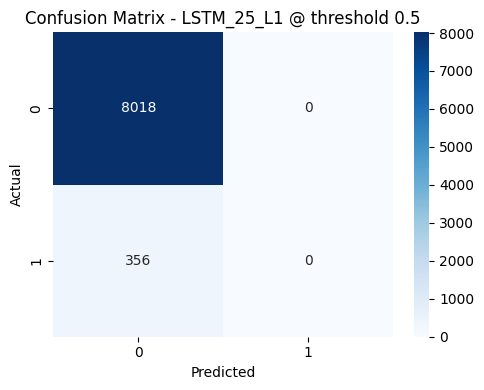


Threshold: 0.4
Accuracy:  0.9575
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000
AUC:       0.5000


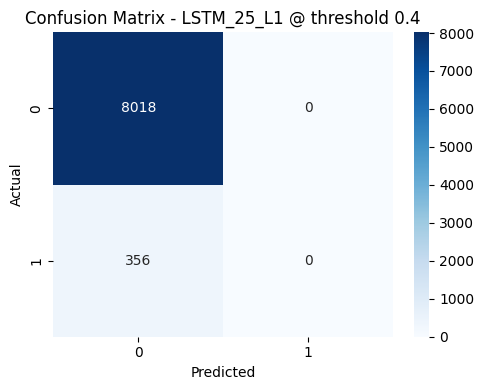


Threshold: 0.3
Accuracy:  0.9575
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000
AUC:       0.5000


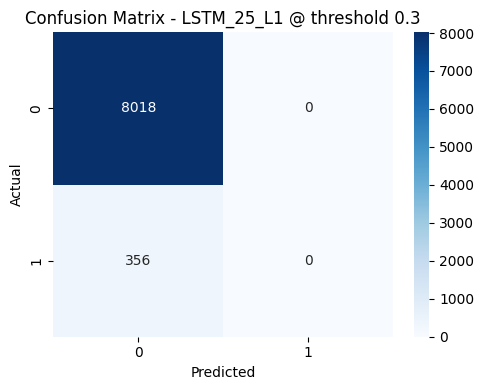


Threshold: 0.2
Accuracy:  0.9575
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000
AUC:       0.5000


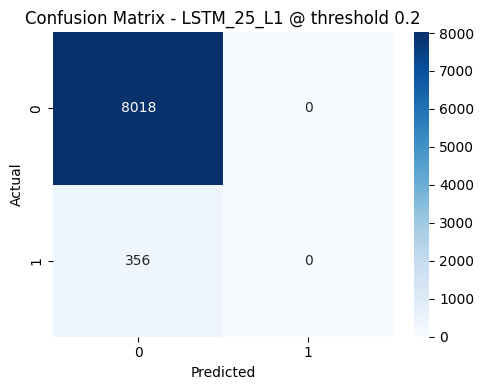


Final Evaluation Results:
                    Accuracy  Precision  Recall  F1-Score     AUC
LSTM_100_thr_0.5      0.9596     0.7812  0.0702    0.1289  0.5347
LSTM_100_thr_0.4      0.9594     0.5800  0.1629    0.2544  0.5788
LSTM_100_thr_0.3      0.9537     0.4208  0.2388    0.3047  0.6121
LSTM_100_thr_0.2      0.9494     0.3988  0.3764    0.3873  0.6756
LSTM_50_thr_0.5       0.9595     0.6977  0.0843    0.1504  0.5413
LSTM_50_thr_0.4       0.9583     0.5327  0.1601    0.2462  0.5769
LSTM_50_thr_0.3       0.9537     0.4328  0.2893    0.3468  0.6362
LSTM_50_thr_0.2       0.9459     0.3753  0.4101    0.3919  0.6899
LSTM_25_L1_thr_0.5    0.9575     0.0000  0.0000    0.0000  0.5000
LSTM_25_L1_thr_0.4    0.9575     0.0000  0.0000    0.0000  0.5000
LSTM_25_L1_thr_0.3    0.9575     0.0000  0.0000    0.0000  0.5000
LSTM_25_L1_thr_0.2    0.9575     0.0000  0.0000    0.0000  0.5000


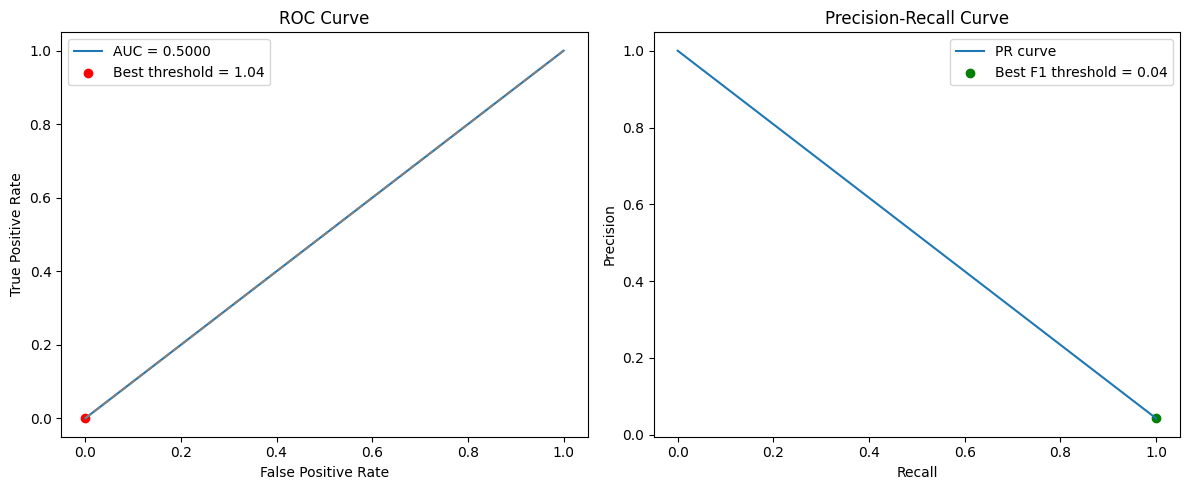


Best threshold by Youden's J (ROC): 1.0434
Best threshold by max F1-score (PR): 0.0434

Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      8018
           1     0.0425    1.0000    0.0816       356

    accuracy                         0.0425      8374
   macro avg     0.0213    0.5000    0.0408      8374
weighted avg     0.0018    0.0425    0.0035      8374



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, precision_recall_curve, classification_report, auc
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1

# --- Assume X and y are already defined as numpy arrays or pandas DataFrame/Series ---
# Example placeholder:
# X = np.random.rand(1000, 10, 1)
# y = np.random.randint(0, 2, 1000)

# --- Evaluation Function ---
def evaluate(y_true, y_pred, threshold):
    print(f"\nThreshold: {threshold}")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"AUC:       {roc_auc_score(y_true, y_pred):.4f}")

# --- Augment Function ---
def augment(X, y):
    noise = np.random.normal(0, 0.01, X.shape)
    return np.vstack((X, X + noise)), np.hstack((y, y))

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, y_train = augment(X_train, y_train)

# --- Model Definitions ---
def define_models(input_shape):
    return {
        "LSTM_100": Sequential([
            LSTM(100, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(50),
            Dropout(0.2),
            Dense(25, activation='relu'),
            Dense(1, activation='sigmoid')
        ]),
        "LSTM_50": Sequential([
            LSTM(50, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(25),
            Dropout(0.2),
            Dense(10, activation='relu'),
            Dense(1, activation='sigmoid')
        ]),
        "LSTM_25_L1": Sequential([
            LSTM(50, return_sequences=True, kernel_regularizer=l1(0.01), input_shape=input_shape),
            Dropout(0.2),
            LSTM(25, kernel_regularizer=l1(0.01)),
            Dropout(0.2),
            Dense(10, activation='relu', kernel_regularizer=l1(0.01)),
            Dense(1, activation='sigmoid')
        ])
    }

# --- Training and Evaluation ---
models = define_models((X.shape[1], X.shape[2]))
results = {}

for name, model in models.items():
    print(f"\nTraining {name} without FOCAL LOSS...")

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    y_pred_prob = model.predict(X_test).flatten()

    for threshold in [0.5, 0.4, 0.3, 0.2]:
        y_pred = (y_pred_prob >= threshold).astype(int)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc_score = roc_auc_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        evaluate(y_test, y_pred, threshold)

        results[f"{name}_thr_{threshold}"] = {
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1,
            "AUC": auc_score
        }

        # Plot Confusion Matrix
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix - {name} @ threshold {threshold}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

# --- Summary Table ---
results_df = pd.DataFrame(results).T
print("\nFinal Evaluation Results:")
print(results_df.round(4))

# --- Optimal Threshold Analysis (using last model's y_pred_prob) ---
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
youden_index = np.argmax(tpr - fpr)
best_roc_threshold = roc_thresholds[youden_index]

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_f1_index = np.argmax(f1_scores)
best_f1_threshold = pr_thresholds[best_f1_index]

# --- Plot ROC & PR Curves ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.scatter(fpr[youden_index], tpr[youden_index], color='red', label=f'Best threshold = {best_roc_threshold:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label="PR curve")
plt.scatter(recall[best_f1_index], precision[best_f1_index], color='green', label=f'Best F1 threshold = {best_f1_threshold:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

# --- Final Optimal Threshold Evaluation ---
best_threshold = best_f1_threshold
y_pred_opt = (y_pred_prob >= best_threshold).astype(int)

print(f"\nBest threshold by Youden's J (ROC): {best_roc_threshold:.4f}")
print(f"Best threshold by max F1-score (PR): {best_f1_threshold:.4f}")

print("\nClassification Report at Optimal Threshold:")
print(classification_report(y_test, y_pred_opt, digits=4))


📊 LSTM Model Comparison
Model	Accuracy	Precision	Recall	F1-Score	AUC
LSTM_100	0.9598	0.7209	0.0871	0.1554	0.5428
LSTM_50	0.9564	0.4746	0.2360	0.3152	0.6122
LSTM_25	0.9575	0.0000	0.0000	0.0000	0.5000

 Key Insights:
LSTM_50 has the best recall (23.6%) and F1-score (0.31) — it's the most balanced.

LSTM_100 has the highest precision (72%) but recall is very low — too conservative.

LSTM_25 failed to detect any positives at all. (100% false negatives)

Interpretation:
LSTM_50 is your best candidate so far for detecting hypoglycemia reliably.

LSTM_100 might be useful when false alarms are costly, but it misses most real events.

LSTM_25 likely over-regularized (due to L2 penalties), silencing detection entirely.

 
 Recommendations:
Stick with LSTM_50 — and tune it:

Try reducing dropout.

Train longer (e.g., 15 epochs).

Use threshold tuning (predict 1 if y_prob > 0.3 instead of 0.5).

Try a Hybrid Model: LSTM_50 + rule-based flag (cgm_min < 70).

Plot Precision-Recall curve or ROC AUC to visualize trade-offs.

Training LSTM_100...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2094/2094 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9544 - loss: 0.1626 - val_accuracy: 0.9582 - val_loss: 0.1327
Epoch 2/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9577 - loss: 0.1398 - val_accuracy: 0.9595 - val_loss: 0.1320
Epoch 3/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9581 - loss: 0.1375 - val_accuracy: 0.9605 - val_loss: 0.1301
Epoch 4/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9596 - loss: 0.1334 - val_accuracy: 0.9589 - val_loss: 0.1352
Epoch 5/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9609 - loss: 0.1351 - val_accuracy: 0.9592 - val_loss: 0.1305
Epoch 6/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9604 - loss: 0.1336 - val_accuracy: 0.9584 - val_loss: 0.1309
Epoch 7/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9597 - loss: 0.1351 - val_accuracy: 0.9583 - val_loss: 0.1283
Epoch 8/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9604 - loss: 0.1326 - val

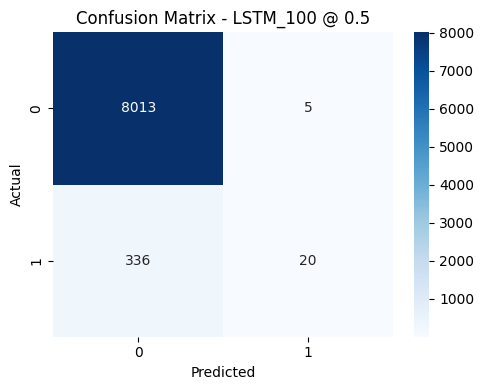


LSTM_100 @ threshold 0.4
Accuracy: 0.9596, Precision: 0.6023, Recall: 0.1489, F1: 0.2387, AUC: 0.5723


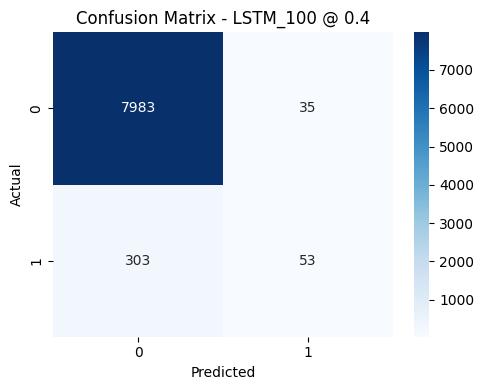


LSTM_100 @ threshold 0.3
Accuracy: 0.9549, Precision: 0.4491, Recall: 0.2725, F1: 0.3392, AUC: 0.6288


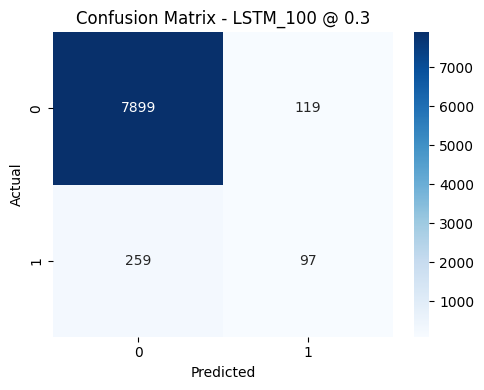


LSTM_100 @ threshold 0.2
Accuracy: 0.9423, Precision: 0.3470, Recall: 0.4045, F1: 0.3735, AUC: 0.6853


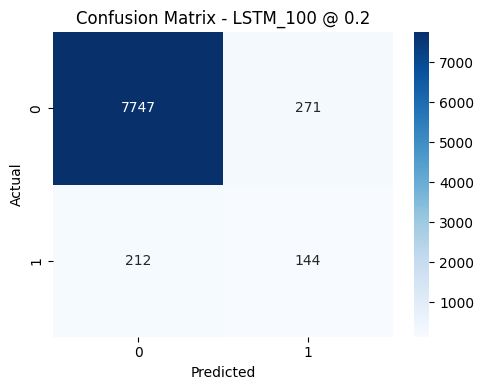

Training LSTM_50...
Epoch 1/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9414 - loss: 0.1850 - val_accuracy: 0.9584 - val_loss: 0.1319
Epoch 2/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9584 - loss: 0.1400 - val_accuracy: 0.9582 - val_loss: 0.1347
Epoch 3/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9598 - loss: 0.1367 - val_accuracy: 0.9601 - val_loss: 0.1302
Epoch 4/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9584 - loss: 0.1386 - val_accuracy: 0.9599 - val_loss: 0.1317
Epoch 5/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9597 - loss: 0.1351 - val_accuracy: 0.9600 - val_loss: 0.1292
Epoch 6/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9580 - loss: 0.1353 - val_accuracy: 0.9596 - val_loss: 0.1307
Epoch 7/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9596 - loss: 0.1350 - val_accuracy: 0.9598 - val_loss: 0.1278
Epoch 8/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accura

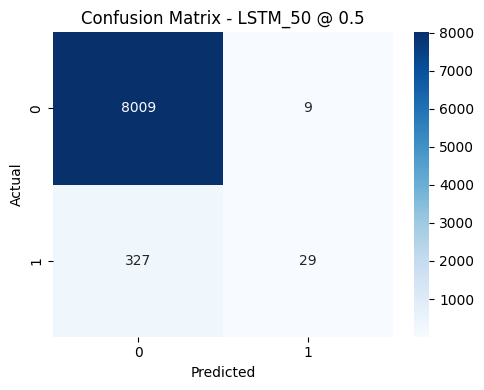


LSTM_50 @ threshold 0.4
Accuracy: 0.9596, Precision: 0.6286, Recall: 0.1236, F1: 0.2066, AUC: 0.5602


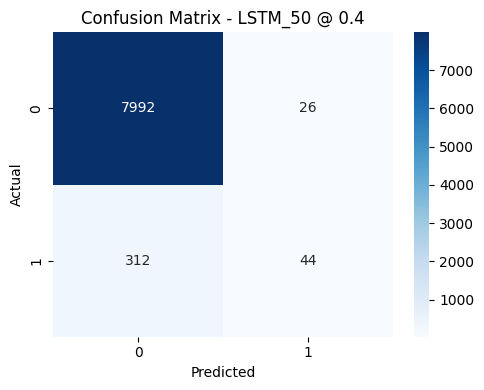


LSTM_50 @ threshold 0.3
Accuracy: 0.9578, Precision: 0.5111, Recall: 0.1938, F1: 0.2811, AUC: 0.5928


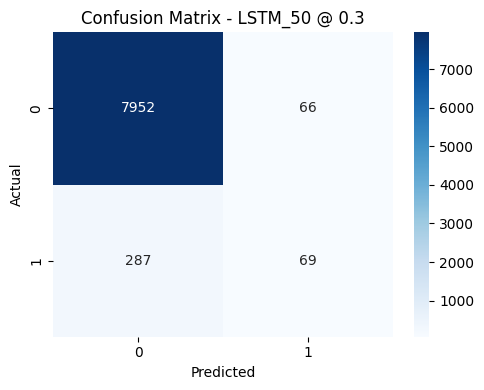


LSTM_50 @ threshold 0.2
Accuracy: 0.9539, Precision: 0.4342, Recall: 0.2781, F1: 0.3390, AUC: 0.6310


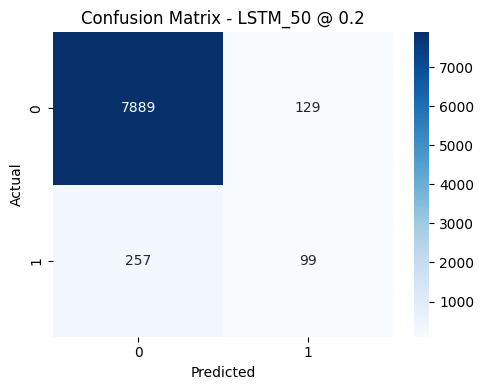

Training LSTM_25_L1...
Epoch 1/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9404 - loss: 1.1144 - val_accuracy: 0.9575 - val_loss: 0.1907
Epoch 2/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9571 - loss: 0.1886 - val_accuracy: 0.9575 - val_loss: 0.1824
Epoch 3/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9583 - loss: 0.1801 - val_accuracy: 0.9575 - val_loss: 0.1844
Epoch 4/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9570 - loss: 0.1840 - val_accuracy: 0.9575 - val_loss: 0.1817
Epoch 5/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9573 - loss: 0.1826 - val_accuracy: 0.9575 - val_loss: 0.1816
Epoch 6/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9573 - loss: 0.1823 - val_accuracy: 0.9575 - val_loss: 0.1817
Epoch 7/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9580 - loss: 0.1805 - val_accuracy: 0.9575 - val_loss: 0.1819
Epoch 8/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - acc

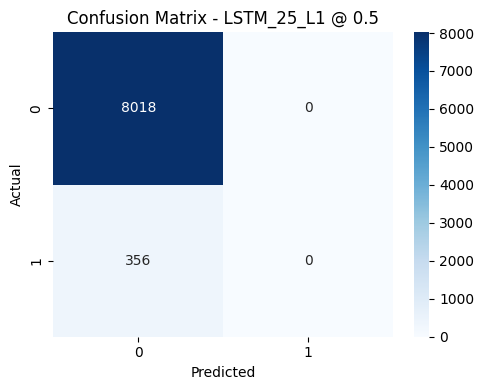


LSTM_25_L1 @ threshold 0.4
Accuracy: 0.9575, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.5000


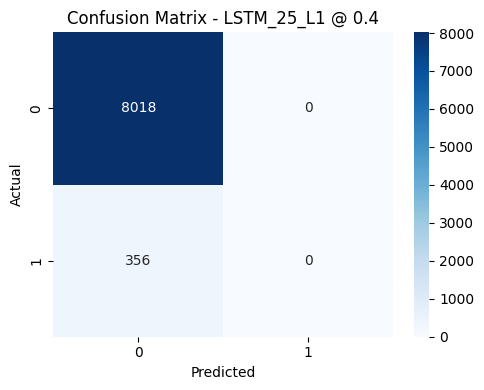


LSTM_25_L1 @ threshold 0.3
Accuracy: 0.9575, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.5000


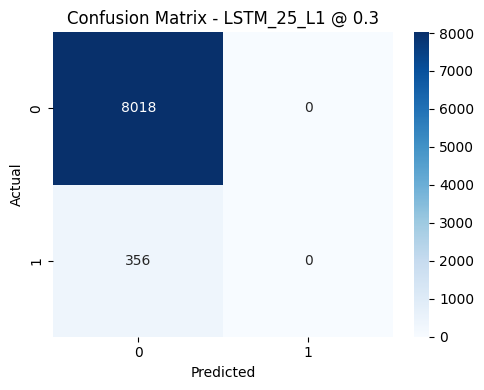


LSTM_25_L1 @ threshold 0.2
Accuracy: 0.9575, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.5000


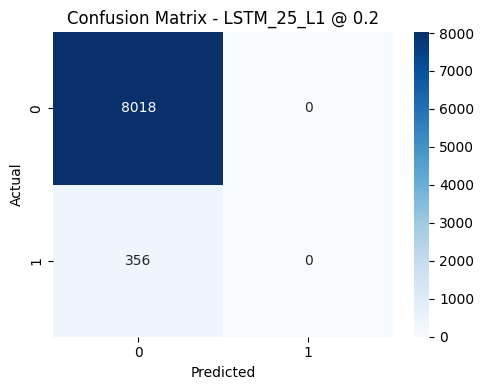


Final Evaluation Results:
                    Accuracy  Precision  Recall  F1-Score     AUC
LSTM_100_thr_0.5      0.9593     0.8000  0.0562    0.1050  0.5278
LSTM_100_thr_0.4      0.9596     0.6023  0.1489    0.2387  0.5723
LSTM_100_thr_0.3      0.9549     0.4491  0.2725    0.3392  0.6288
LSTM_100_thr_0.2      0.9423     0.3470  0.4045    0.3735  0.6853
LSTM_50_thr_0.5       0.9599     0.7632  0.0815    0.1472  0.5402
LSTM_50_thr_0.4       0.9596     0.6286  0.1236    0.2066  0.5602
LSTM_50_thr_0.3       0.9578     0.5111  0.1938    0.2811  0.5928
LSTM_50_thr_0.2       0.9539     0.4342  0.2781    0.3390  0.6310
LSTM_25_L1_thr_0.5    0.9575     0.0000  0.0000    0.0000  0.5000
LSTM_25_L1_thr_0.4    0.9575     0.0000  0.0000    0.0000  0.5000
LSTM_25_L1_thr_0.3    0.9575     0.0000  0.0000    0.0000  0.5000
LSTM_25_L1_thr_0.2    0.9575     0.0000  0.0000    0.0000  0.5000


In [12]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


def evaluate(y_true, y_pred, threshold):
    print(f"\nThreshold: {threshold}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"AUC: {roc_auc_score(y_true, y_pred):.4f}")





# ✅ Focal Loss definition
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_t * tf.math.pow((1 - p_t), gamma) * bce
    return loss


# ✅ Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ✅ Augmentation: add small noise
def augment(X, y):
    noise = np.random.normal(0, 0.01, X.shape)
    return np.vstack((X, X + noise)), np.hstack((y, y))
X_train, y_train = augment(X_train, y_train)

# ✅ Define models
def define_models(input_shape):
    return {
        "LSTM_100": Sequential([
            LSTM(100, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(50),
            Dropout(0.2),
            Dense(25, activation='relu'),
            Dense(1, activation='sigmoid')
        ]),
        "LSTM_50": Sequential([
            LSTM(50, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(25),
            Dropout(0.2),
            Dense(10, activation='relu'),
            Dense(1, activation='sigmoid')
        ]),
      "LSTM_25_L1": Sequential([
    LSTM(50, return_sequences=True, kernel_regularizer=l1(0.01), input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(25, kernel_regularizer=l1(0.01)),
    Dropout(0.2),
    Dense(10, activation='relu', kernel_regularizer=l1(0.01)),
    Dense(1, activation='sigmoid')
])
    }

# ✅ Train and evaluate using focal loss
models = define_models((X.shape[1], X.shape[2]))
results = {}

for name, model in models.items():
    print(f"Training {name}...")

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    y_pred_prob = model.predict(X_test).flatten()

    for threshold in [0.5, 0.4, 0.3, 0.2]:
        y_pred = (y_pred_prob >= threshold).astype(int)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        print(f"\n{name} @ threshold {threshold}")
        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

        # Save results (if needed only once per model or per threshold)
        results[f"{name}_thr_{threshold}"] = {
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1,
            "AUC": auc
        }

        # Confusion Matrix
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix - {name} @ {threshold}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

# Summary Table
results_df = pd.DataFrame(results).T
print("\nFinal Evaluation Results:")
print(results_df.round(4))


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf



🚀 Training LSTM_100 with FOCAL LOSS...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2094/2094 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9532 - loss: 0.0044 - val_accuracy: 0.9575 - val_loss: 0.0019
Epoch 2/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9577 - loss: 0.0021 - val_accuracy: 0.9577 - val_loss: 0.0019
Epoch 3/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9586 - loss: 0.0020 - val_accuracy: 0.9575 - val_loss: 0.0019
Epoch 4/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9587 - loss: 0.0020 - val_accuracy: 0.9577 - val_loss: 0.0019
Epoch 5/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9587 - loss: 0.0020 - val_accuracy: 0.9587 - val_loss: 0.0019
Epoch 6/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9575 - loss: 0.0022 - val_accuracy: 0.9581 - val_loss: 0.0019
Epoch 7/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9584 - loss: 0.0020 - val_accuracy: 0.9602 - val_loss: 0.0019
Epoch 8/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9598 - loss: 0.0019 - val

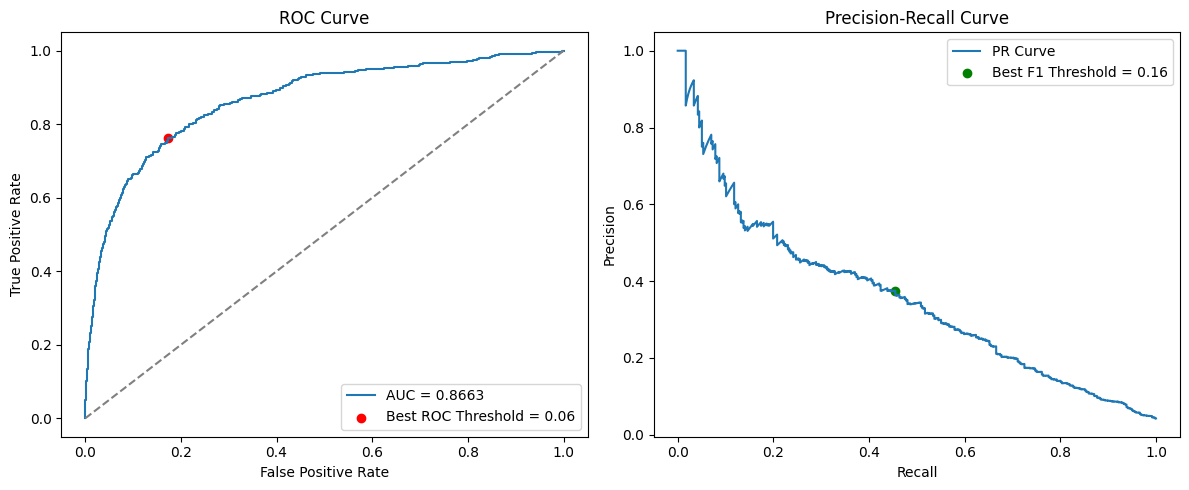

Best threshold by Youden's J statistic (ROC): 0.0607
Best threshold by max F1-score (PR): 0.1622

📊 LSTM_100 @ 0.50 - Evaluation Metrics:
Accuracy: 0.9583, Precision: 0.8889, Recall: 0.0225
F1-Score: 0.0438, AUC: 0.5112
RMSE: 0.2041, MAE: 0.0417


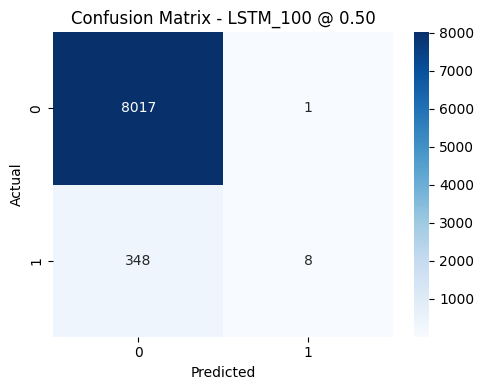


📊 LSTM_100 @ 0.40 - Evaluation Metrics:
Accuracy: 0.9592, Precision: 0.7500, Recall: 0.0590
F1-Score: 0.1094, AUC: 0.5291
RMSE: 0.2021, MAE: 0.0408


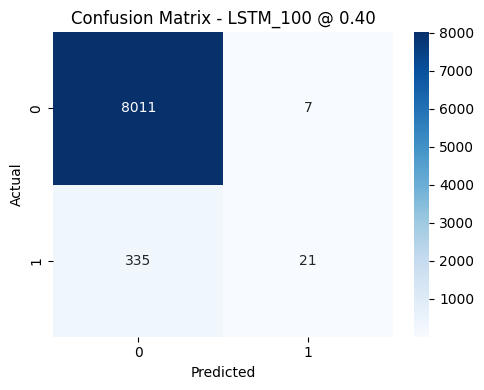


📊 LSTM_100 @ 0.30 - Evaluation Metrics:
Accuracy: 0.9587, Precision: 0.5463, Recall: 0.1657
F1-Score: 0.2543, AUC: 0.5798
RMSE: 0.2033, MAE: 0.0413


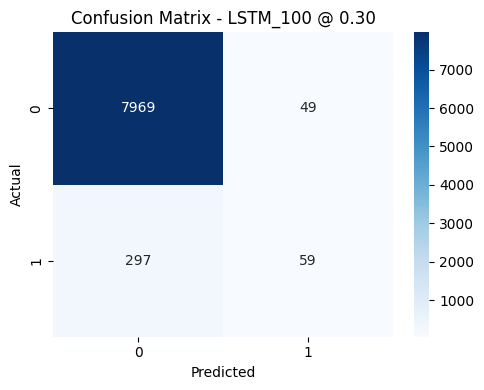


📊 LSTM_100 @ 0.20 - Evaluation Metrics:
Accuracy: 0.9521, Precision: 0.4252, Recall: 0.3596
F1-Score: 0.3896, AUC: 0.6690
RMSE: 0.2188, MAE: 0.0479


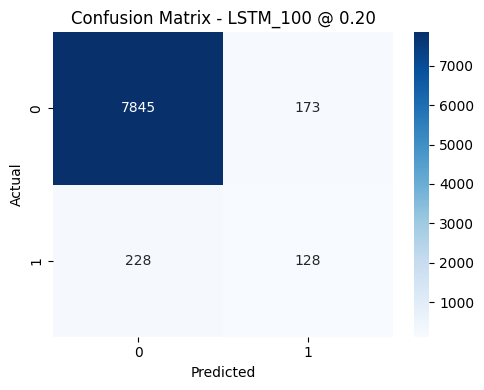


📊 LSTM_100 @ 0.16 - Evaluation Metrics:
Accuracy: 0.9446, Precision: 0.3750, Recall: 0.4551
F1-Score: 0.4112, AUC: 0.7107
RMSE: 0.2354, MAE: 0.0554


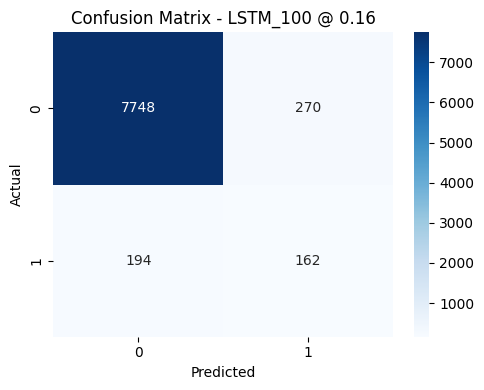


🚀 Training LSTM_50 with FOCAL LOSS...
Epoch 1/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9383 - loss: 0.0109 - val_accuracy: 0.9575 - val_loss: 0.0021
Epoch 2/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9569 - loss: 0.0022 - val_accuracy: 0.9575 - val_loss: 0.0019
Epoch 3/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9590 - loss: 0.0020 - val_accuracy: 0.9575 - val_loss: 0.0020
Epoch 4/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9568 - loss: 0.0021 - val_accuracy: 0.9575 - val_loss: 0.0019
Epoch 5/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9570 - loss: 0.0022 - val_accuracy: 0.9575 - val_loss: 0.0020
Epoch 6/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9583 - loss: 0.0020 - val_accuracy: 0.9575 - val_loss: 0.0019
Epoch 7/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9581 - loss: 0.0021 - val_accuracy: 0.9575 - val_loss: 0.0021
Epoch 8/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14

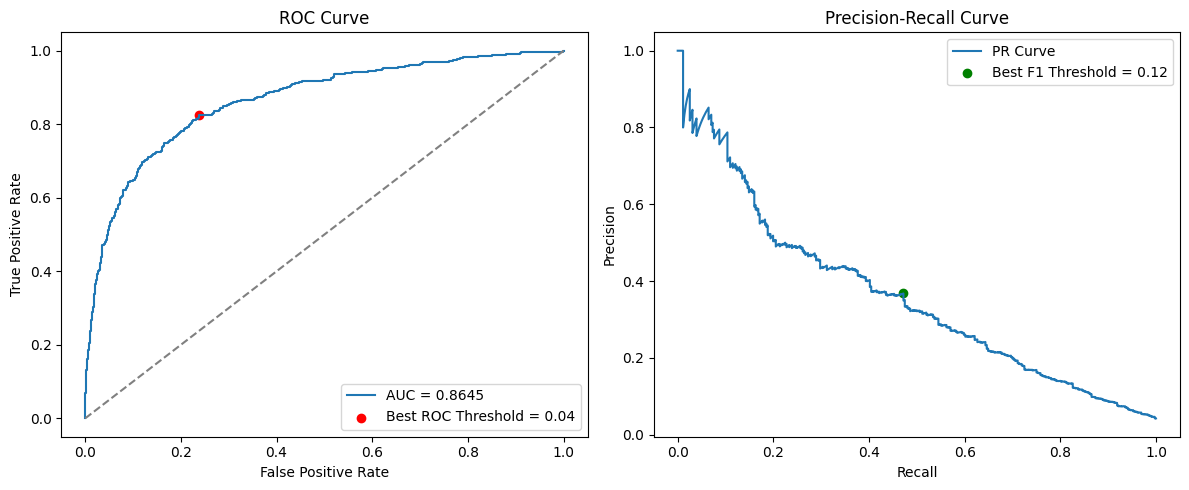

Best threshold by Youden's J statistic (ROC): 0.0420
Best threshold by max F1-score (PR): 0.1190

📊 LSTM_50 @ 0.50 - Evaluation Metrics:
Accuracy: 0.9581, Precision: 0.8571, Recall: 0.0169
F1-Score: 0.0331, AUC: 0.5084
RMSE: 0.2047, MAE: 0.0419


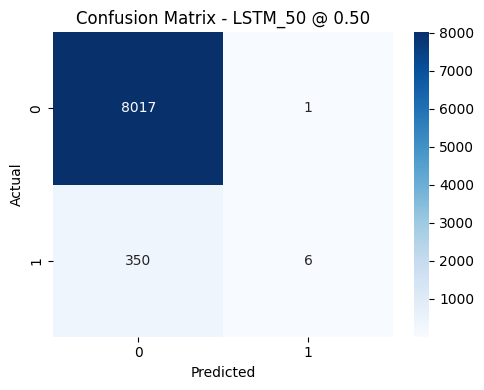


📊 LSTM_50 @ 0.40 - Evaluation Metrics:
Accuracy: 0.9595, Precision: 0.8400, Recall: 0.0590
F1-Score: 0.1102, AUC: 0.5292
RMSE: 0.2012, MAE: 0.0405


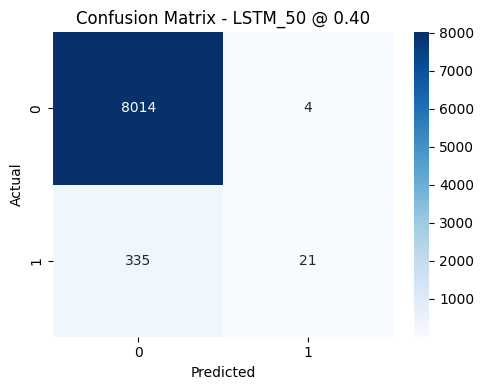


📊 LSTM_50 @ 0.30 - Evaluation Metrics:
Accuracy: 0.9604, Precision: 0.7069, Recall: 0.1152
F1-Score: 0.1981, AUC: 0.5565
RMSE: 0.1991, MAE: 0.0396


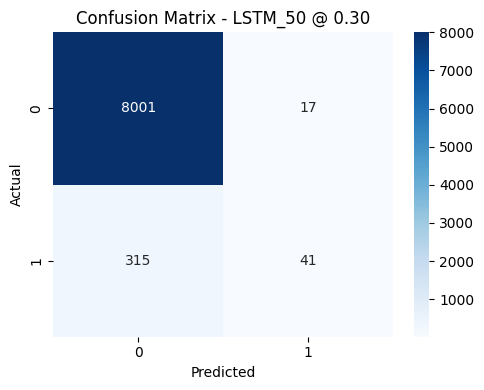


📊 LSTM_50 @ 0.20 - Evaluation Metrics:
Accuracy: 0.9570, Precision: 0.4889, Recall: 0.2472
F1-Score: 0.3284, AUC: 0.6179
RMSE: 0.2073, MAE: 0.0430


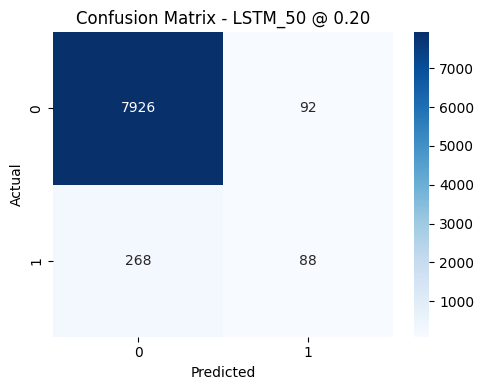


📊 LSTM_50 @ 0.12 - Evaluation Metrics:
Accuracy: 0.9430, Precision: 0.3676, Recall: 0.4719
F1-Score: 0.4133, AUC: 0.7179
RMSE: 0.2387, MAE: 0.0570


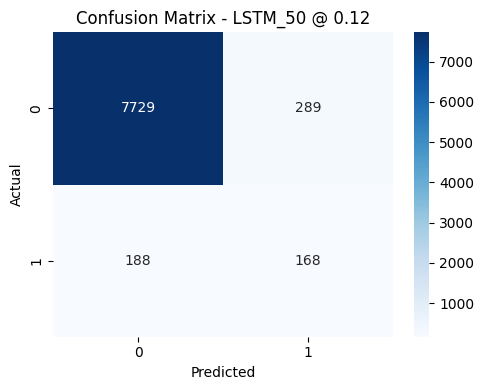


🚀 Training LSTM_25 with FOCAL LOSS...
Epoch 1/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9418 - loss: 0.8541 - val_accuracy: 0.9575 - val_loss: 0.0083
Epoch 2/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9583 - loss: 0.0083 - val_accuracy: 0.9575 - val_loss: 0.0084
Epoch 3/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9576 - loss: 0.0084 - val_accuracy: 0.9575 - val_loss: 0.0084
Epoch 4/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9565 - loss: 0.0084 - val_accuracy: 0.9575 - val_loss: 0.0084
Epoch 5/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9567 - loss: 0.0086 - val_accuracy: 0.9575 - val_loss: 0.0083
Epoch 6/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9570 - loss: 0.0084 - val_accuracy: 0.9575 - val_loss: 0.0084
Epoch 7/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9565 - loss: 0.0085 - val_accuracy: 0.9575 - val_loss: 0.0084
Epoch 8/15
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 14

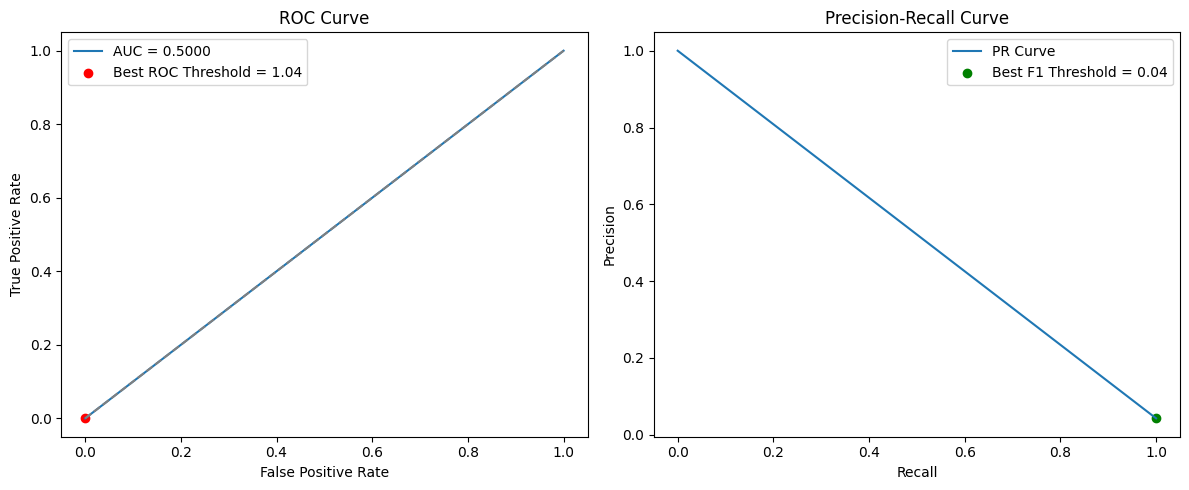

Best threshold by Youden's J statistic (ROC): 1.0446
Best threshold by max F1-score (PR): 0.0446

📊 LSTM_25 @ 0.50 - Evaluation Metrics:
Accuracy: 0.9575, Precision: 0.0000, Recall: 0.0000
F1-Score: 0.0000, AUC: 0.5000
RMSE: 0.2062, MAE: 0.0425


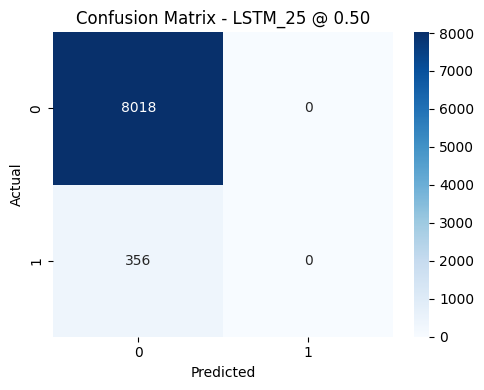


📊 LSTM_25 @ 0.40 - Evaluation Metrics:
Accuracy: 0.9575, Precision: 0.0000, Recall: 0.0000
F1-Score: 0.0000, AUC: 0.5000
RMSE: 0.2062, MAE: 0.0425


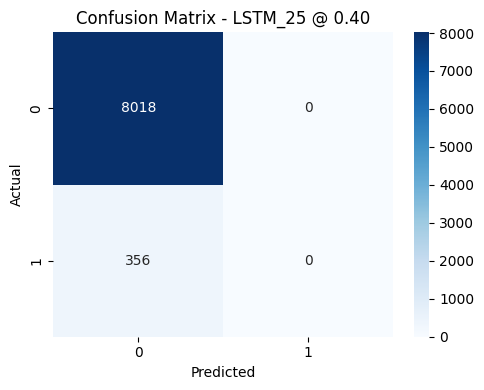


📊 LSTM_25 @ 0.30 - Evaluation Metrics:
Accuracy: 0.9575, Precision: 0.0000, Recall: 0.0000
F1-Score: 0.0000, AUC: 0.5000
RMSE: 0.2062, MAE: 0.0425


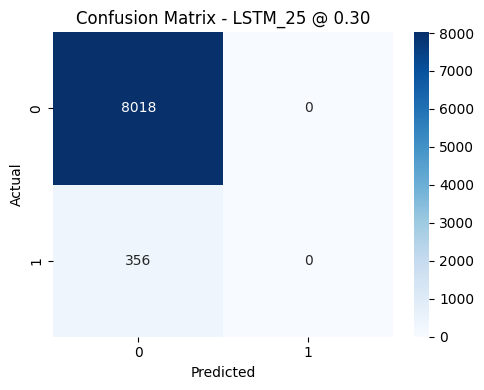


📊 LSTM_25 @ 0.20 - Evaluation Metrics:
Accuracy: 0.9575, Precision: 0.0000, Recall: 0.0000
F1-Score: 0.0000, AUC: 0.5000
RMSE: 0.2062, MAE: 0.0425


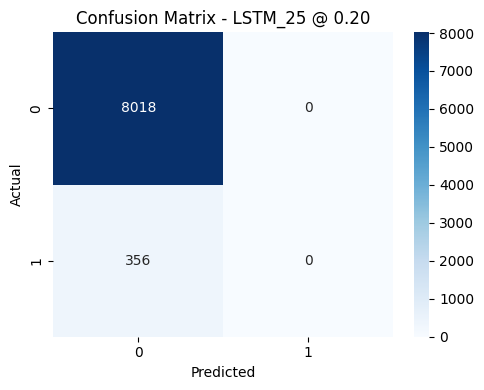


📊 LSTM_25 @ 0.04 - Evaluation Metrics:
Accuracy: 0.0425, Precision: 0.0425, Recall: 1.0000
F1-Score: 0.0816, AUC: 0.5000
RMSE: 0.9785, MAE: 0.9575


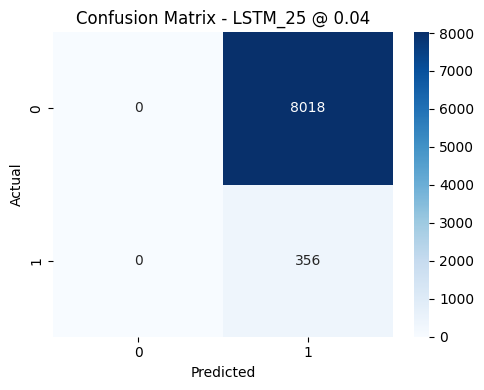


✅ Final Evaluation Results:
                   Accuracy  Precision  Recall  F1-Score     AUC    RMSE  \
LSTM_100_thr_0.50    0.9583     0.8889  0.0225    0.0438  0.5112  0.2041   
LSTM_100_thr_0.40    0.9592     0.7500  0.0590    0.1094  0.5291  0.2021   
LSTM_100_thr_0.30    0.9587     0.5463  0.1657    0.2543  0.5798  0.2033   
LSTM_100_thr_0.20    0.9521     0.4252  0.3596    0.3896  0.6690  0.2188   
LSTM_100_thr_0.16    0.9446     0.3750  0.4551    0.4112  0.7107  0.2354   
LSTM_50_thr_0.50     0.9581     0.8571  0.0169    0.0331  0.5084  0.2047   
LSTM_50_thr_0.40     0.9595     0.8400  0.0590    0.1102  0.5292  0.2012   
LSTM_50_thr_0.30     0.9604     0.7069  0.1152    0.1981  0.5565  0.1991   
LSTM_50_thr_0.20     0.9570     0.4889  0.2472    0.3284  0.6179  0.2073   
LSTM_50_thr_0.12     0.9430     0.3676  0.4719    0.4133  0.7179  0.2387   
LSTM_25_thr_0.50     0.9575     0.0000  0.0000    0.0000  0.5000  0.2062   
LSTM_25_thr_0.40     0.9575     0.0000  0.0000    0.0000  0

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l1
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, mean_squared_error, mean_absolute_error,
    roc_curve, precision_recall_curve, auc
)

# ✅ Focal Loss
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_t * tf.pow(1 - p_t, gamma) * bce
    return loss

# ✅ Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ✅ Augmentation
def augment(X, y):
    noise = np.random.normal(0, 0.01, X.shape)
    return np.vstack((X, X + noise)), np.hstack((y, y))

X_train, y_train = augment(X_train, y_train)

# ✅ Define Models
def define_models(input_shape):
    return {
        "LSTM_100": Sequential([
            LSTM(100, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(50),
            Dropout(0.2),
            Dense(25, activation='relu'),
            Dense(1, activation='sigmoid')
        ]),
        "LSTM_50": Sequential([
            LSTM(50, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(25),
            Dropout(0.2),
            Dense(10, activation='relu'),
            Dense(1, activation='sigmoid')
        ]),
        "LSTM_25": Sequential([
            LSTM(50, return_sequences=True, kernel_regularizer=l1(0.01), input_shape=input_shape),
            Dropout(0.3),
            LSTM(25, kernel_regularizer=l1(0.01)),
            Dropout(0.3),
            Dense(10, activation='relu', kernel_regularizer=l1(0.01)),
            Dense(1, activation='sigmoid')
        ])
    }

# ✅ Evaluation Function
def evaluate_with_regression_metrics(y_true, y_pred, model_name="LSTM"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc_score = roc_auc_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n📊 {model_name} - Evaluation Metrics:")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}, AUC: {auc_score:.4f}")
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "AUC": auc_score,
        "RMSE": rmse,
        "MAE": mae
    }

# ✅ Training and Evaluation
models = define_models((X.shape[1], X.shape[2]))
results = {}

for name, model in models.items():
    print(f"\n🚀 Training {name} with FOCAL LOSS...")
    model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    y_pred_prob = model.predict(X_test).flatten()

    # 📈 ROC and PR Curve Analysis (once per model)
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    youden_index = np.argmax(tpr - fpr)
    best_roc_threshold = roc_thresholds[youden_index]

    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_f1_index = np.argmax(f1_scores)
    best_f1_threshold = pr_thresholds[best_f1_index]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.scatter(fpr[youden_index], tpr[youden_index], color='red', label=f'Best ROC Threshold = {best_roc_threshold:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label='PR Curve')
    plt.scatter(recall[best_f1_index], precision[best_f1_index], color='green', label=f'Best F1 Threshold = {best_f1_threshold:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Best threshold by Youden's J statistic (ROC): {best_roc_threshold:.4f}")
    print(f"Best threshold by max F1-score (PR): {best_f1_threshold:.4f}")

    # 📊 Evaluate using fixed thresholds
    for threshold in [0.5, 0.4, 0.3, 0.2, best_f1_threshold]:
        y_pred = (y_pred_prob >= threshold).astype(int)
        metrics = evaluate_with_regression_metrics(y_test, y_pred, model_name=f"{name} @ {threshold:.2f}")
        results[f"{name}_thr_{threshold:.2f}"] = metrics

# ✅ Summary Table
results_df = pd.DataFrame(results).T
print("\n✅ Final Evaluation Results:")
print(results_df.round(4))


In [15]:
from collections import Counter

# Count the class distribution
full_distribution = Counter(y)
train_distribution = Counter(y_train)
test_distribution = Counter(y_test)

# Display results clearly
print("🔢 Class Distribution Summary")
print(f"➡️ Full Dataset     : {dict(full_distribution)}")
print(f"➡️ Training Set     : {dict(train_distribution)}")
print(f"➡️ Testing Set      : {dict(test_distribution)}")

# Optionally, show class proportions
def class_proportions(counter):
    total = sum(counter.values())
    return {cls: f"{count} ({count/total:.2%})" for cls, count in counter.items()}

print("\n📊 Class Proportions")
print(f"Full    : {class_proportions(full_distribution)}")
print(f"Train   : {class_proportions(train_distribution)}")
print(f"Test    : {class_proportions(test_distribution)}")


🔢 Class Distribution Summary
➡️ Full Dataset     : {0: 40087, 1: 1780}
➡️ Training Set     : {0: 64138, 1: 2848}
➡️ Testing Set      : {0: 8018, 1: 356}

📊 Class Proportions
Full    : {0: '40087 (95.75%)', 1: '1780 (4.25%)'}
Train   : {0: '64138 (95.75%)', 1: '2848 (4.25%)'}
Test    : {0: '8018 (95.75%)', 1: '356 (4.25%)'}


In [16]:
from sklearn.utils import resample
import numpy as np
from collections import Counter

# Flatten LSTM format for under-sampling
X_flat = X_train.reshape(X_train.shape[0], -1)

# Separate the classes
X_majority = X_flat[y_train == 0]
X_minority = X_flat[y_train == 1]

y_majority = y_train[y_train == 0]
y_minority = y_train[y_train == 1]

# Downsample majority class
X_majority_down, y_majority_down = resample(
    X_majority, y_majority,
    replace=False,
    n_samples=len(y_minority),
    random_state=42
)

# Combine balanced data
X_balanced = np.vstack((X_majority_down, X_minority))
y_balanced = np.hstack((y_majority_down, y_minority))

# Shuffle the balanced data
indices = np.random.permutation(len(y_balanced))
X_balanced = X_balanced[indices]
y_balanced = y_balanced[indices]

# Reshape back to LSTM format
X_balanced = X_balanced.reshape(-1, X_train.shape[1], X_train.shape[2])

# Report new distribution
print("✅ Balanced Class Distribution:", Counter(y_balanced))


✅ Balanced Class Distribution: Counter({1: 2848, 0: 2848})


✅ Balanced Class Distribution: Counter({1: 2848, 0: 2848})

🚀 Training LSTM_100 
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5570 - loss: 0.0651 - val_accuracy: 0.9108 - val_loss: 0.0187
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7371 - loss: 0.0395 - val_accuracy: 0.9170 - val_loss: 0.0161
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7313 - loss: 0.0408 - val_accuracy: 0.8955 - val_loss: 0.0232
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7471 - loss: 0.0363 - val_accuracy: 0.8749 - val_loss: 0.0285
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7715 - loss: 0.0329 - val_accuracy: 0.9526 - val_loss: 0.0074
Epoch 6/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7441 - loss: 0.0356 - val_accuracy: 0.8727 - val_loss: 0.0319
Epoch 7/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7504 - loss: 0.0357 - val_accuracy: 0.9034 - val_loss: 0.0227
Epoch 8/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7516 - loss: 0.0339 - val_accuracy: 0.872

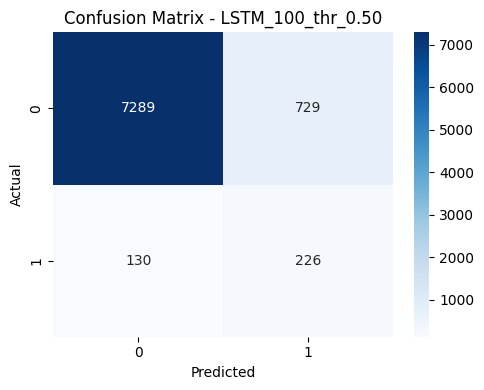


📊 LSTM_100_thr_0.40 Performance:
Accuracy : 0.8642 | Precision : 0.1937
Recall   : 0.6938 | F1-Score  : 0.3029
AUC      : 0.7828 | RMSE     : 0.3685 | MAE : 0.1358


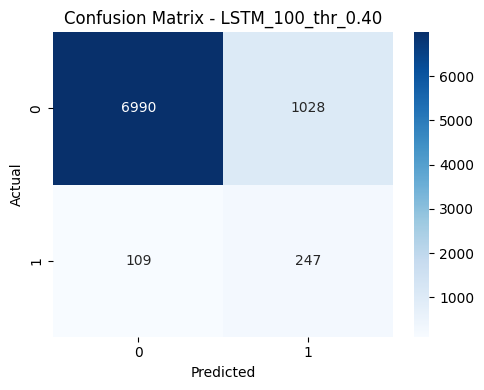


📊 LSTM_100_thr_0.30 Performance:
Accuracy : 0.7957 | Precision : 0.1451
Recall   : 0.7781 | F1-Score  : 0.2446
AUC      : 0.7873 | RMSE     : 0.4520 | MAE : 0.2043


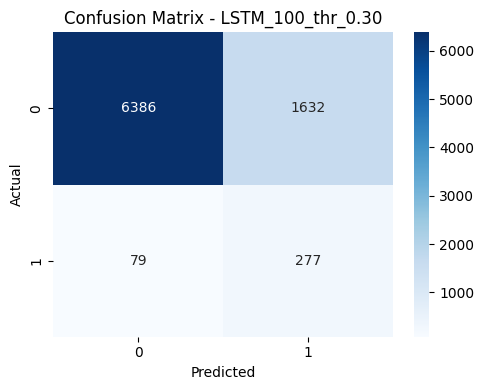


📊 LSTM_100_thr_0.20 Performance:
Accuracy : 0.5973 | Precision : 0.0880
Recall   : 0.9045 | F1-Score  : 0.1604
AUC      : 0.7441 | RMSE     : 0.6346 | MAE : 0.4027


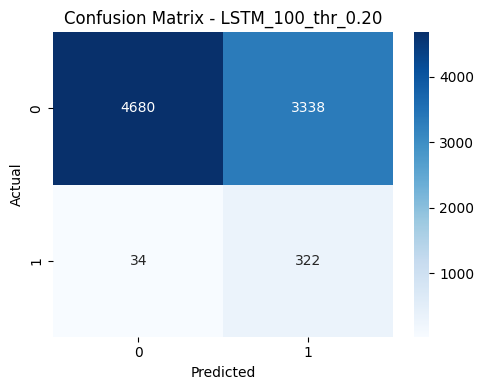


📊 LSTM_100_thr_0.71 Performance:
Accuracy : 0.9445 | Precision : 0.3687
Recall   : 0.4298 | F1-Score  : 0.3969
AUC      : 0.6985 | RMSE     : 0.2356 | MAE : 0.0555


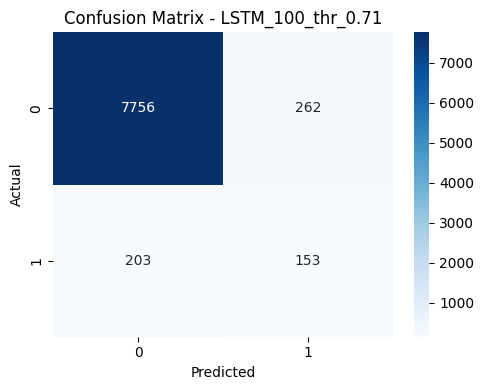

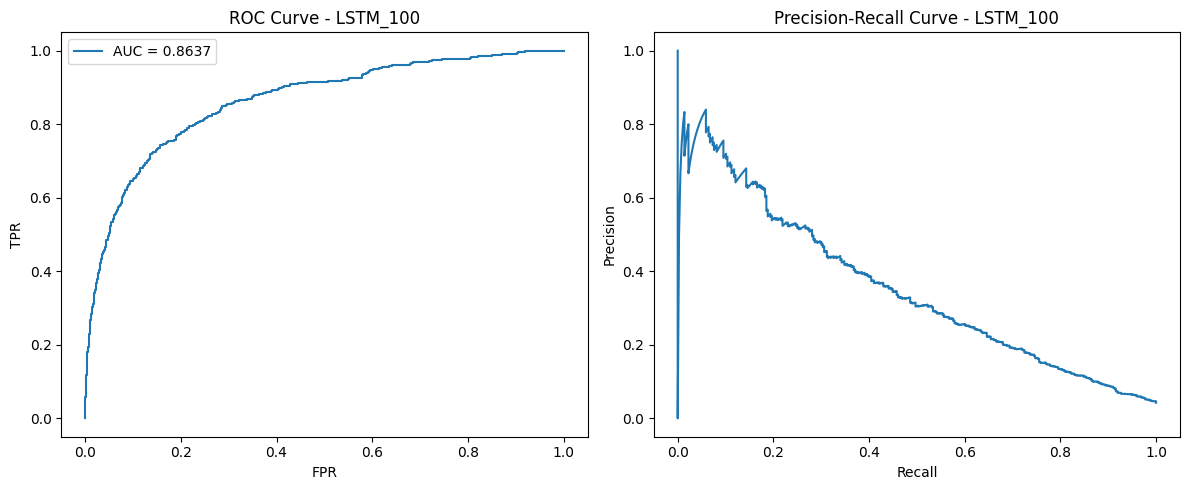


🚀 Training LSTM_50 
Epoch 1/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5019 - loss: 0.0748 - val_accuracy: 0.9098 - val_loss: 0.0291
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6689 - loss: 0.0507 - val_accuracy: 0.9030 - val_loss: 0.0221
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7204 - loss: 0.0415 - val_accuracy: 0.9263 - val_loss: 0.0165
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7186 - loss: 0.0411 - val_accuracy: 0.8848 - val_loss: 0.0283
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7432 - loss: 0.0362 - val_accuracy: 0.9030 - val_loss: 0.0257
Epoch 6/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7435 - loss: 0.0385 - val_accuracy: 0.8956 - val_loss: 0.0257
Epoch 7/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7431 - loss: 0.0364 - val_accuracy: 0.9158 - val_loss: 0.0204
Epoch 8/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7271 - lo

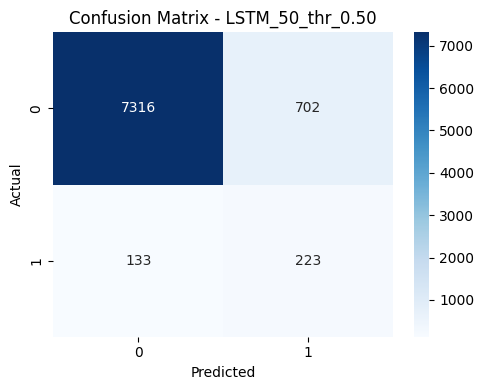


📊 LSTM_50_thr_0.40 Performance:
Accuracy : 0.8704 | Precision : 0.2005
Recall   : 0.6854 | F1-Score  : 0.3102
AUC      : 0.7820 | RMSE     : 0.3600 | MAE : 0.1296


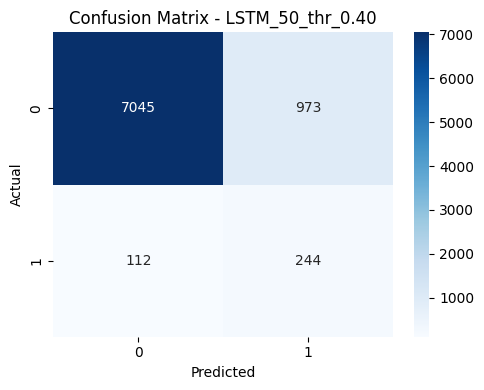


📊 LSTM_50_thr_0.30 Performance:
Accuracy : 0.8227 | Precision : 0.1610
Recall   : 0.7528 | F1-Score  : 0.2652
AUC      : 0.7893 | RMSE     : 0.4211 | MAE : 0.1773


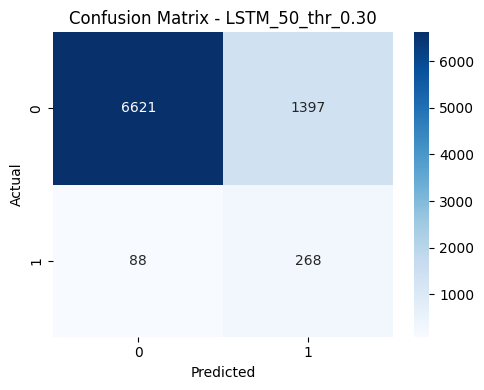


📊 LSTM_50_thr_0.20 Performance:
Accuracy : 0.5939 | Precision : 0.0864
Recall   : 0.8933 | F1-Score  : 0.1575
AUC      : 0.7369 | RMSE     : 0.6373 | MAE : 0.4061


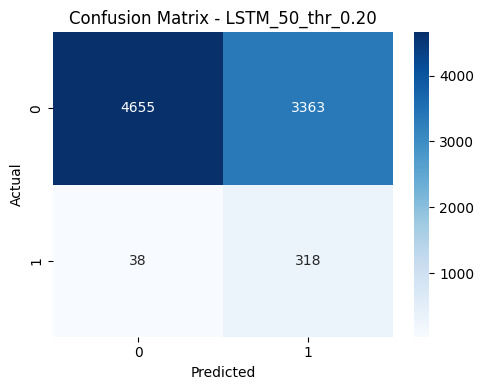


📊 LSTM_50_thr_0.66 Performance:
Accuracy : 0.9313 | Precision : 0.3160
Recall   : 0.5281 | F1-Score  : 0.3954
AUC      : 0.7387 | RMSE     : 0.2620 | MAE : 0.0687


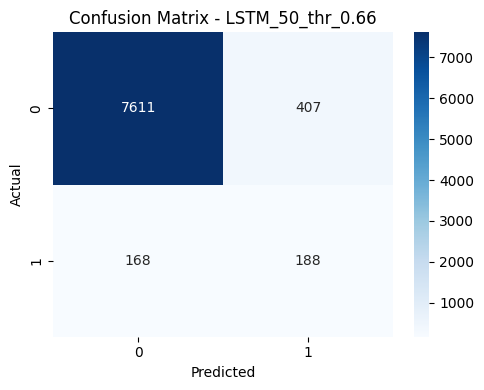

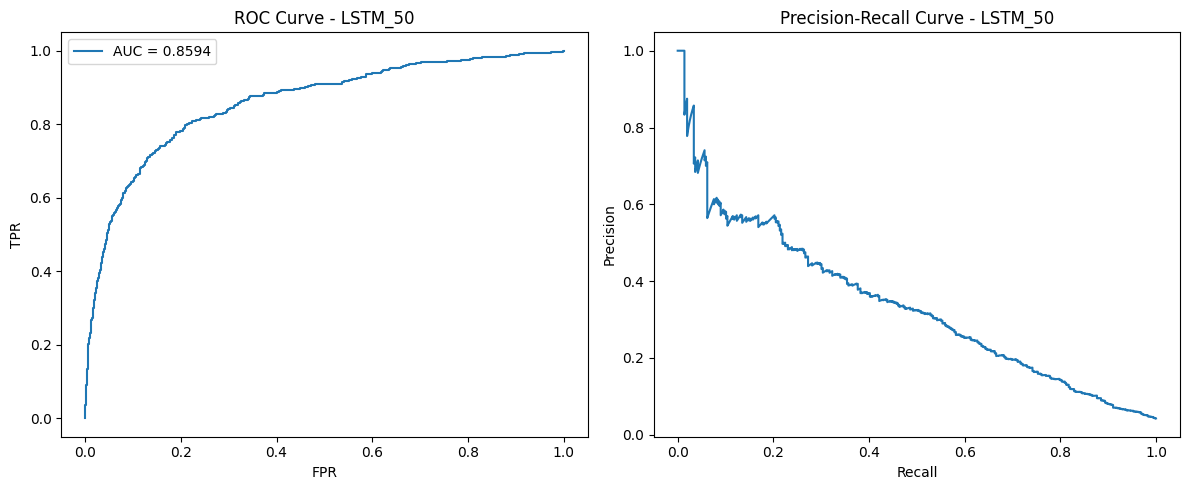


🚀 Training LSTM_25 
Epoch 1/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4870 - loss: 3.8439 - val_accuracy: 0.9575 - val_loss: 0.3070
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4903 - loss: 0.2102 - val_accuracy: 0.9575 - val_loss: 0.0591
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4934 - loss: 0.0838 - val_accuracy: 0.9575 - val_loss: 0.0448
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4992 - loss: 0.0797 - val_accuracy: 0.9575 - val_loss: 0.0478
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4989 - loss: 0.0797 - val_accuracy: 0.9575 - val_loss: 0.0480
Epoch 6/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4908 - loss: 0.0803 - val_accuracy: 0.9575 - val_loss: 0.0456
Epoch 7/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5024 - loss: 0.0794 - val_accuracy: 0.9575 - val_loss: 0.0471
Epoch 8/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4904 - lo

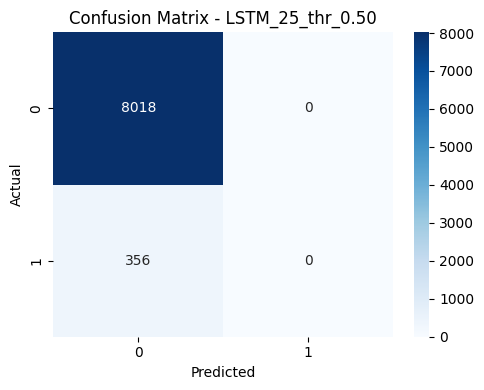


📊 LSTM_25_thr_0.40 Performance:
Accuracy : 0.9575 | Precision : 0.0000
Recall   : 0.0000 | F1-Score  : 0.0000
AUC      : 0.5000 | RMSE     : 0.2062 | MAE : 0.0425


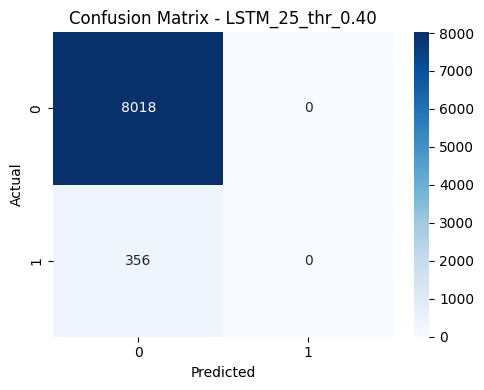


📊 LSTM_25_thr_0.30 Performance:
Accuracy : 0.0425 | Precision : 0.0425
Recall   : 1.0000 | F1-Score  : 0.0816
AUC      : 0.5000 | RMSE     : 0.9785 | MAE : 0.9575


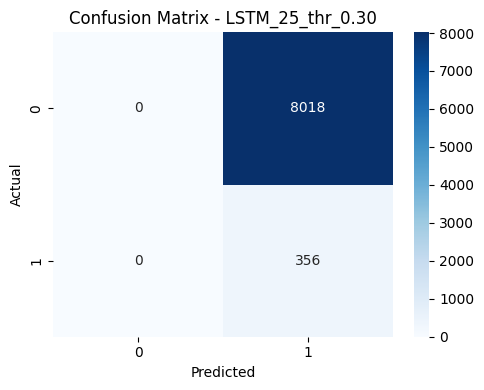


📊 LSTM_25_thr_0.20 Performance:
Accuracy : 0.0425 | Precision : 0.0425
Recall   : 1.0000 | F1-Score  : 0.0816
AUC      : 0.5000 | RMSE     : 0.9785 | MAE : 0.9575


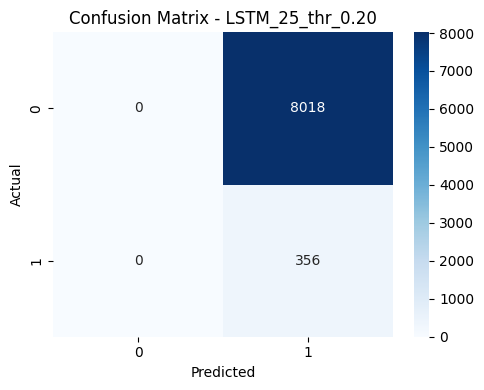


📊 LSTM_25_thr_0.36 Performance:
Accuracy : 0.0425 | Precision : 0.0425
Recall   : 1.0000 | F1-Score  : 0.0816
AUC      : 0.5000 | RMSE     : 0.9785 | MAE : 0.9575


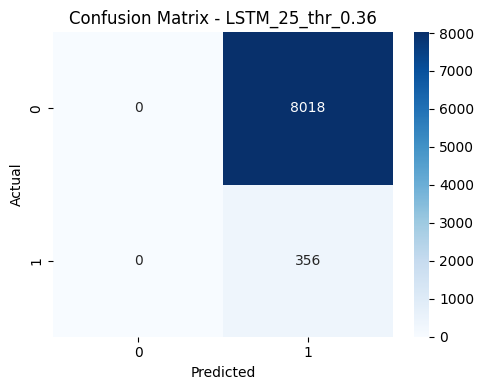

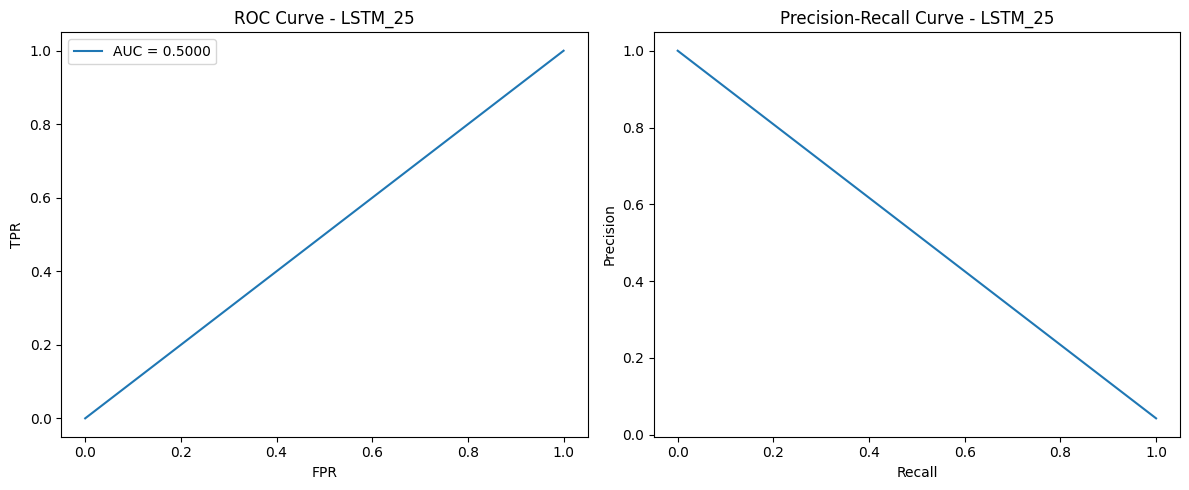


✅ Final Evaluation Results:
                   Accuracy  Precision  Recall  F1-Score     AUC    RMSE  \
LSTM_100_thr_0.50    0.8974     0.2366  0.6348    0.3448  0.7720  0.3203   
LSTM_100_thr_0.40    0.8642     0.1937  0.6938    0.3029  0.7828  0.3685   
LSTM_100_thr_0.30    0.7957     0.1451  0.7781    0.2446  0.7873  0.4520   
LSTM_100_thr_0.20    0.5973     0.0880  0.9045    0.1604  0.7441  0.6346   
LSTM_100_thr_0.71    0.9445     0.3687  0.4298    0.3969  0.6985  0.2356   
LSTM_50_thr_0.50     0.9003     0.2411  0.6264    0.3482  0.7694  0.3158   
LSTM_50_thr_0.40     0.8704     0.2005  0.6854    0.3102  0.7820  0.3600   
LSTM_50_thr_0.30     0.8227     0.1610  0.7528    0.2652  0.7893  0.4211   
LSTM_50_thr_0.20     0.5939     0.0864  0.8933    0.1575  0.7369  0.6373   
LSTM_50_thr_0.66     0.9313     0.3160  0.5281    0.3954  0.7387  0.2620   
LSTM_25_thr_0.50     0.9575     0.0000  0.0000    0.0000  0.5000  0.2062   
LSTM_25_thr_0.40     0.9575     0.0000  0.0000    0.0000  0

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l1
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, mean_squared_error, mean_absolute_error,
    roc_curve, precision_recall_curve, auc
)
from sklearn.utils import resample
from collections import Counter

# -------------------- Split and Augment --------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

def augment(X, y):
    noise = np.random.normal(0, 0.01, X.shape)
    return np.vstack((X, X + noise)), np.hstack((y, y))

X_train, y_train = augment(X_train, y_train)

# -------------------- Undersample Majority Class --------------------
X_flat = X_train.reshape(X_train.shape[0], -1)
X_majority = X_flat[y_train == 0]
X_minority = X_flat[y_train == 1]
y_majority = y_train[y_train == 0]
y_minority = y_train[y_train == 1]

X_majority_down, y_majority_down = resample(
    X_majority, y_majority,
    replace=False,
    n_samples=len(y_minority),
    random_state=42
)

X_balanced = np.vstack((X_majority_down, X_minority))
y_balanced = np.hstack((y_majority_down, y_minority))

# Shuffle and reshape
shuffle_idx = np.random.permutation(len(y_balanced))
X_balanced = X_balanced[shuffle_idx].reshape(-1, X.shape[1], X.shape[2])
y_balanced = y_balanced[shuffle_idx]

print("✅ Balanced Class Distribution:", Counter(y_balanced))

# -------------------- Define Focal Loss --------------------
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_t * tf.math.pow(1 - p_t, gamma) * bce
    return loss

# -------------------- Define LSTM Models --------------------
def define_models(input_shape):
    return {
        "LSTM_100": Sequential([
            LSTM(100, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(50),
            Dropout(0.2),
            Dense(25, activation='relu'),
            Dense(1, activation='sigmoid')
        ]),
        "LSTM_50": Sequential([
            LSTM(50, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(25),
            Dropout(0.2),
            Dense(10, activation='relu'),
            Dense(1, activation='sigmoid')
        ]),
        "LSTM_25": Sequential([
            LSTM(50, return_sequences=True, kernel_regularizer=l1(0.01), input_shape=input_shape),
            Dropout(0.3),
            LSTM(25, kernel_regularizer=l1(0.01)),
            Dropout(0.3),
            Dense(10, activation='relu', kernel_regularizer=l1(0.01)),
            Dense(1, activation='sigmoid')
        ])
    }

# -------------------- Evaluation Function --------------------
def evaluate_model(y_true, y_pred, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc_score = roc_auc_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n📊 {model_name} Performance:")
    print(f"Accuracy : {acc:.4f} | Precision : {prec:.4f}")
    print(f"Recall   : {rec:.4f} | F1-Score  : {f1:.4f}")
    print(f"AUC      : {auc_score:.4f} | RMSE     : {rmse:.4f} | MAE : {mae:.4f}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return {
        "Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1,
        "AUC": auc_score, "RMSE": rmse, "MAE": mae
    }

# -------------------- Train + Evaluate --------------------
results = {}
models = define_models((X.shape[1], X.shape[2]))

for name, model in models.items():
    print(f"\n🚀 Training {name} ")
    model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
    model.fit(X_balanced, y_balanced, epochs=15, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Predictions
    y_pred_prob = model.predict(X_test).flatten()
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob)
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob)

    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_threshold = pr_thresholds[np.argmax(f1_scores)]

    # Evaluation at best threshold
    for threshold in [0.5, 0.4, 0.3, 0.2, best_threshold]:
        y_pred = (y_pred_prob >= threshold).astype(int)
        key = f"{name}_thr_{threshold:.2f}"
        results[key] = evaluate_model(y_test, y_pred, key)

    # ROC & PR plots
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.4f}")
    plt.title(f"ROC Curve - {name}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision)
    plt.title(f"Precision-Recall Curve - {name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.tight_layout()
    plt.show()

# -------------------- Summary Table --------------------
results_df = pd.DataFrame(results).T
print("\n✅ Final Evaluation Results:")
print(results_df.round(4))
